# Deep Learning in Active Magnetic Regenerators

This Notebook presents the results for the application of Neural Networks in the prediction of the Cooling Capacity ($\dot{Q}_\mathrm{C}$ or $Qc$) and the Magnetization Power ($\dot{W}_\mathrm{m}$ or $Wm$) of Active Magnetic Regenerators. The Dataset consists in 532 points coming from numerical simulations.

### Importing the Modules

In [23]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import pathlib

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import joblib

tf.config.optimizer.set_jit(True)
mpl.style.use('default')
plt.rc('text',usetex = True)
plt.rc('font', family='serif',size = 12)

### Plotting Functions 

In [24]:
def plot_results(y_train,y_pred_train,y_test,y_pred_test,Obj):
    
    plt.figure()
    plt.plot(y_train,y_pred_train,'.',markersize = 7,color = '#1f77b4', mfc='none', label = 'Training Set')
    plt.plot(y_test,y_pred_test,'x' ,markersize = 5, color = '#2ca02c', mfc='none',label = 'Test Set',)
    
    if Obj == 'Qc':
        Aux = np.linspace(50,300)
        plt.plot(Aux,0.95*Aux,'k--')
        plt.plot(Aux,1.05*Aux,'k--')
        plt.text(140, 180, '$+ 5 \%$', fontsize=12)
        plt.text(150, 120, '$- 5 \%$', fontsize=12)
        plt.legend()
        plt.ylabel(r' $\dot{Q}_\mathrm{C,AMR}$ [W] - ANN' )
        plt.xlabel(r' $\dot{Q}_\mathrm{C,AMR}$ [W] - Numerical Solution')
        plt.grid(linestyle='dotted')
        plt.savefig('Plots/Qc/Qc - NN.pdf', format = 'pdf', bbox_inches='tight') 
    
    elif Obj == 'Wm':
        Aux = np.linspace(10,60)
        plt.plot(Aux,0.95*Aux,'k--')
        plt.plot(Aux,1.05*Aux,'k--')
        plt.text(23, 17, '$- 5 \%$', fontsize=12)
        plt.text(19, 28, '$+ 5 \%$', fontsize=12)
        plt.legend()
        plt.ylabel(r' $\dot{W}_\mathrm{AMR,mag}$ [W] - ANN' )
        plt.xlabel(r' $\dot{W}_\mathrm{AMR,mag}$ [W] - Numerical Solution')
        plt.grid(linestyle='dotted')
        plt.savefig('Plots/Wm/Wm - NN.pdf', format = 'pdf', bbox_inches='tight') 

### Reading the Input Parameteres 

The independent variable are the Width ($H$), Height ($H$) and Length ($L$) of the porous medium, the frequency ($f$) and mass flow rate ($mf$) of the Active Magnetic Regenerator, the Inlet Temperatures at the Hot ($Th$) and Cold ($Tc$) ends and the Applied Magnetic Field ($B$).

The dependent variables are the Cooling Capacity ($Qc$) and Magnetization Power ($Wm$).

In [25]:
Inputs = pd.read_excel('Data/Data_AMR.xlsx',index_col = 0, dtype=np.float32) # Input Data
X = Inputs[['W','H','f','mf','B','L','Th','Tc']]
y = Inputs[['Qc','Wm']]

### Train-Test Split

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size = 0.2,
                                                    random_state = 42)  

### Scaling the Features

In [27]:
#sc = joblib.load('Models/AMR_Scaler.pkl')
#X_train = sc.fit_transform(X_train)
#X_test = sc.transform(X_test)

In [28]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [29]:
joblib.dump(sc, 'Models/AMR_Scaler.pkl') 

['Models/AMR_Scaler.pkl']

### Building the Model

In [30]:
def Build(hp):
    
    #Grouping a stack of Layers in Model
    model = tf.keras.Sequential()
    model.add(BatchNormalization())
    # Adding the Layers
    # The number of layers, neurons in each one and activation functions are going to be tunned 
    for i in range(hp.Int('layers', 0, 2)):
        model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i), 1, 201, step=2),
                                        activation=hp.Choice('act_' + str(i), ['relu','sigmoid','selu'])))
        #model.add(Dropout(0.2))
        #Applying a Batch Normalization Layer after Dense Layer
        model.add(BatchNormalization())

        
    # Adding a final Layer 
    model.add(tf.keras.layers.Dense(1, activation='selu'))
    
    #model = tfmot.quantization.keras.quantize_model(model)
    # Compiling the Model with the Adam optimization algorithm
    model.compile(optimizer=Adam(),
                            loss="mean_squared_error",
                            metrics = ['accuracy']
                            )
    return model

### Batch Optimization

Overriding run_trial in MyTuner (https://kegui.medium.com/how-to-tune-the-number-of-epochs-and-batch-size-in-keras-tuner-c2ab2d40878d)

In [31]:
class MyTuner(kt.Hyperband):
    def run_trial(self, trial, *args, **kwargs):
        kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 1, 501, step=5)
        return super(MyTuner, self).run_trial(trial, *args, **kwargs)

### Defining the Tuner

In [32]:
def NeuNet(X_train,y_train,max_epochs,Obj):
    
    # Defining the Tuner
    tuner = MyTuner(Build,
                    objective = 'val_loss',
                    max_epochs = max_epochs,
                    directory='KT_Dir',
                    project_name='KT_Hyperband_' + Obj,
                    executions_per_trial = 1,   
    )
    
    # Hyperparameter Optimization
    tuner.search(X_train,
                 y_train[Obj],
                 epochs=max_epochs,
                 callbacks=[EarlyStopping('val_loss', patience=5)],
                 verbose=1,
                 validation_split=0.2)
    
  
    # Trainning the Best Model
    best_model = tuner.get_best_models()[0]
    best_model.build(X_train.shape)
    best_model.fit(X_train,
                   y_train[Obj], 
                   epochs=max_epochs,
                   batch_size=tuner.get_best_hyperparameters(num_trials=1)[0].get('batch_size')
    )
    best_model.summary()
    
    # Saving the Model
    best_model.save('Models/'+Obj+'/'+ Obj +'_NN.h5', include_optimizer=False)
    best_model.save('Models/'+Obj+'/'+ Obj +'_NN', include_optimizer=False)
    best_model.save_weights('Models/'+Obj+'/'+ Obj +'_weights.h5')
    #joblib.dump(best_model, 'Models/'+Obj+'/'+ Obj +'_NN.pkl')
    
     #R2 for the Training Set
    print('The coefficient of determination for '+ Obj +' Training Set using Neural Networks is '+
          str(r2_score(y_train[Obj], best_model.predict(X_train))))

    # R2 for the Test Set
    print('The coefficient of determination for '+ Obj +' Test Set using Neural Networks is '+
          str(r2_score(y_test[Obj], best_model.predict(X_test)))) 

    # Plotting the Results
    plot_results(y_train[Obj], best_model.predict(X_train), y_test[Obj], best_model.predict(X_test), Obj) 

### Defining a Test Function

In [33]:
def Test(X_train,y_train,Obj, Scal):
    
    Model = load_model('Models/'+Obj+'/'+ Obj +'_NN.h5', compile = False)
    Model.summary()
    Model.summary()
    for i, layer in enumerate (Model.layers):
        print (i, layer)
        try:
            print ("    ",layer.activation)
        except AttributeError:
            print('   no activation attribute')
            
    #R2 for the Training Set
    print('The coefficient of determination for '+ Obj +' Training Set using Neural Networks is '+
          str(r2_score(y_train[Obj], Model.predict(Scal.transform(X_train)))))

    # R2 for the Test Set
    print('The coefficient of determination for '+ Obj +' Test Set using Neural Networks is '+
          str(r2_score(y_test[Obj], Model.predict(Scal.transform(X_test))))) 

    # Plotting the Results
    plot_results(y_train[Obj], Model.predict(Scal.transform(X_train)), y_test[Obj], Model.predict(Scal.transform(X_test)), Obj) 

In [34]:
def Test_lite(X_train,y_train,Obj, Scal):
    
    Model = load_model('Models/'+Obj+'/'+ Obj +'_NN.h5', compile = False)
    Model.summary()
    for i, layer in enumerate (Model.layers):
        print (i, layer)
        try:
            print ("    ",layer.activation)
        except AttributeError:
            print('   no activation attribute')
    converter = tf.lite.TFLiteConverter.from_keras_model(Model)
    tflite_model = converter.convert()
    tflite_models_dir = pathlib.Path("/")
    tflite_models_dir.mkdir(exist_ok=True, parents=True)
    tflite_model_file = tflite_models_dir/"mnist_model.tflite"
    tflite_model_file.write_bytes(tflite_model)
    
    interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
    interpreter.allocate_tensors()
    
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]
    
    Train_Lite = []
    for i in range(np.shape(X_train)[0]):
        interpreter.set_tensor(input_index, Scaller.transform(X_train)[i].reshape(-1,1).T)
        interpreter.invoke()
        Train_Lite.append(interpreter.get_tensor(output_index)[0][0])
        
    Test_Lite = []
    for i in range(np.shape(X_test)[0]):
        interpreter.set_tensor(input_index, Scaller.transform(X_test)[i].reshape(-1,1).T)
        interpreter.invoke()
        Test_Lite.append(interpreter.get_tensor(output_index)[0][0])
    
    #R2 for the Training Set
    print('The coefficient of determination for '+ Obj +' Training Set using Neural Networks is '+
          str(r2_score(y_train[Obj], Train_Lite)))

    # R2 for the Test Set
    print('The coefficient of determination for '+ Obj +' Test Set using Neural Networks is '+
          str(r2_score(y_test[Obj], Test_Lite)))    
    
    # Plotting the Results
    plot_results(y_train[Obj], Train_Lite, y_test[Obj], Test_Lite, Obj) 

### Training the Models

Trial 2074 Complete [00h 00m 31s]
val_loss: 1751.5911865234375

Best val_loss So Far: 42.981117248535156
Total elapsed time: 02h 35m 11s
INFO:tensorflow:Oracle triggered exit
Epoch 1/1500
27/27 [==============================] - 1s 2ms/step - loss: 203.4044 - accuracy: 0.0000e+00
Epoch 2/1500
27/27 [==============================] - 0s 2ms/step - loss: 227.4981 - accuracy: 0.0000e+00
Epoch 3/1500
27/27 [==============================] - 0s 2ms/step - loss: 263.9858 - accuracy: 0.0000e+00
Epoch 4/1500
27/27 [==============================] - 0s 1ms/step - loss: 252.5271 - accuracy: 0.0000e+00
Epoch 5/1500
27/27 [==============================] - 0s 2ms/step - loss: 176.4823 - accuracy: 0.0000e+00
Epoch 6/1500
27/27 [==============================] - 0s 1ms/step - loss: 248.3610 - accuracy: 0.0000e+00
Epoch 7/1500
27/27 [==============================] - 0s 1ms/step - loss: 238.8575 - accuracy: 0.0000e+00
Epoch 8/1500
27/27 [==============================] - 0s 2ms/step - loss: 228.7821 

27/27 [==============================] - 0s 1ms/step - loss: 167.8240 - accuracy: 0.0000e+00
Epoch 77/1500
27/27 [==============================] - 0s 2ms/step - loss: 181.8622 - accuracy: 0.0000e+00
Epoch 78/1500
27/27 [==============================] - 0s 2ms/step - loss: 169.6270 - accuracy: 0.0000e+00
Epoch 79/1500
27/27 [==============================] - 0s 1ms/step - loss: 200.0209 - accuracy: 0.0000e+00
Epoch 80/1500
27/27 [==============================] - 0s 1ms/step - loss: 182.3958 - accuracy: 0.0000e+00
Epoch 81/1500
27/27 [==============================] - 0s 1ms/step - loss: 216.3225 - accuracy: 0.0000e+00
Epoch 82/1500
27/27 [==============================] - 0s 2ms/step - loss: 215.7510 - accuracy: 0.0000e+00
Epoch 83/1500
27/27 [==============================] - 0s 2ms/step - loss: 191.0161 - accuracy: 0.0000e+00
Epoch 84/1500
27/27 [==============================] - 0s 1ms/step - loss: 160.5368 - accuracy: 0.0000e+00
Epoch 85/1500
27/27 [==============================

27/27 [==============================] - 0s 2ms/step - loss: 246.9256 - accuracy: 0.0000e+00
Epoch 153/1500
27/27 [==============================] - 0s 2ms/step - loss: 210.3425 - accuracy: 0.0000e+00
Epoch 154/1500
27/27 [==============================] - 0s 2ms/step - loss: 169.1830 - accuracy: 0.0000e+00
Epoch 155/1500
27/27 [==============================] - 0s 2ms/step - loss: 175.7894 - accuracy: 0.0000e+00
Epoch 156/1500
27/27 [==============================] - 0s 1ms/step - loss: 206.7172 - accuracy: 0.0000e+00
Epoch 157/1500
27/27 [==============================] - 0s 2ms/step - loss: 160.8605 - accuracy: 0.0000e+00
Epoch 158/1500
27/27 [==============================] - 0s 2ms/step - loss: 212.9157 - accuracy: 0.0000e+00
Epoch 159/1500
27/27 [==============================] - 0s 2ms/step - loss: 176.5633 - accuracy: 0.0000e+00
Epoch 160/1500
27/27 [==============================] - 0s 2ms/step - loss: 189.1597 - accuracy: 0.0000e+00
Epoch 161/1500
27/27 [=====================

Epoch 228/1500
27/27 [==============================] - 0s 1ms/step - loss: 183.7571 - accuracy: 0.0000e+00
Epoch 229/1500
27/27 [==============================] - 0s 1ms/step - loss: 207.9141 - accuracy: 0.0000e+00
Epoch 230/1500
27/27 [==============================] - 0s 1ms/step - loss: 191.1524 - accuracy: 0.0000e+00
Epoch 231/1500
27/27 [==============================] - 0s 1ms/step - loss: 231.9326 - accuracy: 0.0000e+00
Epoch 232/1500
27/27 [==============================] - 0s 2ms/step - loss: 227.1874 - accuracy: 0.0000e+00
Epoch 233/1500
27/27 [==============================] - 0s 2ms/step - loss: 180.3140 - accuracy: 0.0000e+00
Epoch 234/1500
27/27 [==============================] - 0s 2ms/step - loss: 218.2939 - accuracy: 0.0000e+00
Epoch 235/1500
27/27 [==============================] - 0s 1ms/step - loss: 170.5000 - accuracy: 0.0000e+00
Epoch 236/1500
27/27 [==============================] - 0s 2ms/step - loss: 241.7469 - accuracy: 0.0000e+00
Epoch 237/1500
27/27 [======

27/27 [==============================] - 0s 2ms/step - loss: 208.8437 - accuracy: 0.0000e+00
Epoch 304/1500
27/27 [==============================] - 0s 1ms/step - loss: 206.0815 - accuracy: 0.0000e+00
Epoch 305/1500
27/27 [==============================] - 0s 1ms/step - loss: 214.2326 - accuracy: 0.0000e+00
Epoch 306/1500
27/27 [==============================] - 0s 2ms/step - loss: 182.2301 - accuracy: 0.0000e+00
Epoch 307/1500
27/27 [==============================] - 0s 2ms/step - loss: 175.1962 - accuracy: 0.0000e+00
Epoch 308/1500
27/27 [==============================] - 0s 2ms/step - loss: 223.0934 - accuracy: 0.0000e+00
Epoch 309/1500
27/27 [==============================] - 0s 2ms/step - loss: 165.8771 - accuracy: 0.0000e+00
Epoch 310/1500
27/27 [==============================] - 0s 2ms/step - loss: 259.5873 - accuracy: 0.0000e+00
Epoch 311/1500
27/27 [==============================] - 0s 2ms/step - loss: 221.3479 - accuracy: 0.0000e+00
Epoch 312/1500
27/27 [=====================

Epoch 379/1500
27/27 [==============================] - 0s 1ms/step - loss: 170.0885 - accuracy: 0.0000e+00
Epoch 380/1500
27/27 [==============================] - 0s 2ms/step - loss: 139.8081 - accuracy: 0.0000e+00
Epoch 381/1500
27/27 [==============================] - 0s 1ms/step - loss: 202.8832 - accuracy: 0.0000e+00
Epoch 382/1500
27/27 [==============================] - 0s 2ms/step - loss: 190.1888 - accuracy: 0.0000e+00
Epoch 383/1500
27/27 [==============================] - 0s 1ms/step - loss: 140.1239 - accuracy: 0.0000e+00
Epoch 384/1500
27/27 [==============================] - 0s 1ms/step - loss: 197.2615 - accuracy: 0.0000e+00
Epoch 385/1500
27/27 [==============================] - 0s 2ms/step - loss: 216.8383 - accuracy: 0.0000e+00
Epoch 386/1500
27/27 [==============================] - 0s 2ms/step - loss: 250.2156 - accuracy: 0.0000e+00
Epoch 387/1500
27/27 [==============================] - 0s 1ms/step - loss: 170.9382 - accuracy: 0.0000e+00
Epoch 388/1500
27/27 [======

27/27 [==============================] - 0s 2ms/step - loss: 147.6564 - accuracy: 0.0000e+00
Epoch 455/1500
27/27 [==============================] - 0s 2ms/step - loss: 201.4496 - accuracy: 0.0000e+00
Epoch 456/1500
27/27 [==============================] - 0s 2ms/step - loss: 196.9345 - accuracy: 0.0000e+00
Epoch 457/1500
27/27 [==============================] - 0s 2ms/step - loss: 186.8386 - accuracy: 0.0000e+00
Epoch 458/1500
27/27 [==============================] - 0s 2ms/step - loss: 230.9344 - accuracy: 0.0000e+00
Epoch 459/1500
27/27 [==============================] - 0s 2ms/step - loss: 170.6256 - accuracy: 0.0000e+00
Epoch 460/1500
27/27 [==============================] - 0s 1ms/step - loss: 204.2492 - accuracy: 0.0000e+00
Epoch 461/1500
27/27 [==============================] - 0s 2ms/step - loss: 180.5029 - accuracy: 0.0000e+00
Epoch 462/1500
27/27 [==============================] - 0s 2ms/step - loss: 159.7072 - accuracy: 0.0000e+00
Epoch 463/1500
27/27 [=====================

Epoch 530/1500
27/27 [==============================] - 0s 2ms/step - loss: 174.8464 - accuracy: 0.0000e+00
Epoch 531/1500
27/27 [==============================] - 0s 2ms/step - loss: 153.2095 - accuracy: 0.0000e+00
Epoch 532/1500
27/27 [==============================] - 0s 1ms/step - loss: 143.4641 - accuracy: 0.0000e+00
Epoch 533/1500
27/27 [==============================] - 0s 1ms/step - loss: 217.4043 - accuracy: 0.0000e+00
Epoch 534/1500
27/27 [==============================] - 0s 2ms/step - loss: 214.9479 - accuracy: 0.0000e+00
Epoch 535/1500
27/27 [==============================] - 0s 1ms/step - loss: 178.2398 - accuracy: 0.0000e+00
Epoch 536/1500
27/27 [==============================] - 0s 2ms/step - loss: 211.3900 - accuracy: 0.0000e+00
Epoch 537/1500
27/27 [==============================] - 0s 1ms/step - loss: 216.7737 - accuracy: 0.0000e+00
Epoch 538/1500
27/27 [==============================] - 0s 1ms/step - loss: 212.6877 - accuracy: 0.0000e+00
Epoch 539/1500
27/27 [======

27/27 [==============================] - 0s 2ms/step - loss: 213.8853 - accuracy: 0.0000e+00
Epoch 606/1500
27/27 [==============================] - 0s 1ms/step - loss: 105.1289 - accuracy: 0.0000e+00
Epoch 607/1500
27/27 [==============================] - 0s 1ms/step - loss: 145.4048 - accuracy: 0.0000e+00
Epoch 608/1500
27/27 [==============================] - 0s 1ms/step - loss: 155.0776 - accuracy: 0.0000e+00
Epoch 609/1500
27/27 [==============================] - 0s 1ms/step - loss: 219.8526 - accuracy: 0.0000e+00
Epoch 610/1500
27/27 [==============================] - 0s 2ms/step - loss: 193.8678 - accuracy: 0.0000e+00
Epoch 611/1500
27/27 [==============================] - 0s 1ms/step - loss: 192.2283 - accuracy: 0.0000e+00
Epoch 612/1500
27/27 [==============================] - 0s 1ms/step - loss: 234.7349 - accuracy: 0.0000e+00
Epoch 613/1500
27/27 [==============================] - 0s 2ms/step - loss: 152.0325 - accuracy: 0.0000e+00
Epoch 614/1500
27/27 [=====================

Epoch 681/1500
27/27 [==============================] - 0s 2ms/step - loss: 145.1767 - accuracy: 0.0000e+00
Epoch 682/1500
27/27 [==============================] - 0s 1ms/step - loss: 151.2702 - accuracy: 0.0000e+00
Epoch 683/1500
27/27 [==============================] - 0s 2ms/step - loss: 197.6506 - accuracy: 0.0000e+00
Epoch 684/1500
27/27 [==============================] - 0s 2ms/step - loss: 229.2628 - accuracy: 0.0000e+00
Epoch 685/1500
27/27 [==============================] - 0s 2ms/step - loss: 155.8278 - accuracy: 0.0000e+00
Epoch 686/1500
27/27 [==============================] - 0s 2ms/step - loss: 166.6071 - accuracy: 0.0000e+00
Epoch 687/1500
27/27 [==============================] - 0s 1ms/step - loss: 169.3089 - accuracy: 0.0000e+00
Epoch 688/1500
27/27 [==============================] - 0s 2ms/step - loss: 211.5896 - accuracy: 0.0000e+00
Epoch 689/1500
27/27 [==============================] - 0s 2ms/step - loss: 177.6597 - accuracy: 0.0000e+00
Epoch 690/1500
27/27 [======

27/27 [==============================] - 0s 2ms/step - loss: 136.4987 - accuracy: 0.0000e+00
Epoch 757/1500
27/27 [==============================] - 0s 1ms/step - loss: 161.5599 - accuracy: 0.0000e+00
Epoch 758/1500
27/27 [==============================] - 0s 2ms/step - loss: 156.7523 - accuracy: 0.0000e+00
Epoch 759/1500
27/27 [==============================] - 0s 2ms/step - loss: 168.9279 - accuracy: 0.0000e+00
Epoch 760/1500
27/27 [==============================] - 0s 1ms/step - loss: 183.0451 - accuracy: 0.0000e+00
Epoch 761/1500
27/27 [==============================] - 0s 1ms/step - loss: 148.1128 - accuracy: 0.0000e+00
Epoch 762/1500
27/27 [==============================] - 0s 1ms/step - loss: 209.0777 - accuracy: 0.0000e+00
Epoch 763/1500
27/27 [==============================] - 0s 2ms/step - loss: 186.2861 - accuracy: 0.0000e+00
Epoch 764/1500
27/27 [==============================] - 0s 2ms/step - loss: 194.7667 - accuracy: 0.0000e+00
Epoch 765/1500
27/27 [=====================

Epoch 832/1500
27/27 [==============================] - 0s 2ms/step - loss: 188.2312 - accuracy: 0.0000e+00
Epoch 833/1500
27/27 [==============================] - 0s 2ms/step - loss: 132.7325 - accuracy: 0.0000e+00
Epoch 834/1500
27/27 [==============================] - 0s 2ms/step - loss: 145.3245 - accuracy: 0.0000e+00
Epoch 835/1500
27/27 [==============================] - 0s 2ms/step - loss: 173.8359 - accuracy: 0.0000e+00
Epoch 836/1500
27/27 [==============================] - 0s 2ms/step - loss: 187.5775 - accuracy: 0.0000e+00
Epoch 837/1500
27/27 [==============================] - 0s 2ms/step - loss: 208.6972 - accuracy: 0.0000e+00
Epoch 838/1500
27/27 [==============================] - 0s 1ms/step - loss: 184.6489 - accuracy: 0.0000e+00
Epoch 839/1500
27/27 [==============================] - 0s 2ms/step - loss: 204.4716 - accuracy: 0.0000e+00
Epoch 840/1500
27/27 [==============================] - 0s 2ms/step - loss: 217.0319 - accuracy: 0.0000e+00
Epoch 841/1500
27/27 [======

27/27 [==============================] - 0s 2ms/step - loss: 147.6132 - accuracy: 0.0000e+00
Epoch 908/1500
27/27 [==============================] - 0s 1ms/step - loss: 147.8257 - accuracy: 0.0000e+00
Epoch 909/1500
27/27 [==============================] - 0s 1ms/step - loss: 226.3797 - accuracy: 0.0000e+00
Epoch 910/1500
27/27 [==============================] - 0s 2ms/step - loss: 142.2678 - accuracy: 0.0000e+00
Epoch 911/1500
27/27 [==============================] - 0s 1ms/step - loss: 170.2380 - accuracy: 0.0000e+00
Epoch 912/1500
27/27 [==============================] - 0s 2ms/step - loss: 118.8107 - accuracy: 0.0000e+00
Epoch 913/1500
27/27 [==============================] - 0s 2ms/step - loss: 166.4867 - accuracy: 0.0000e+00
Epoch 914/1500
27/27 [==============================] - 0s 1ms/step - loss: 144.9890 - accuracy: 0.0000e+00
Epoch 915/1500
27/27 [==============================] - 0s 2ms/step - loss: 158.9196 - accuracy: 0.0000e+00
Epoch 916/1500
27/27 [=====================

Epoch 983/1500
27/27 [==============================] - 0s 2ms/step - loss: 176.5377 - accuracy: 0.0000e+00
Epoch 984/1500
27/27 [==============================] - 0s 2ms/step - loss: 208.7636 - accuracy: 0.0000e+00
Epoch 985/1500
27/27 [==============================] - 0s 1ms/step - loss: 172.9077 - accuracy: 0.0000e+00
Epoch 986/1500
27/27 [==============================] - 0s 2ms/step - loss: 142.5537 - accuracy: 0.0000e+00
Epoch 987/1500
27/27 [==============================] - 0s 1ms/step - loss: 118.0832 - accuracy: 0.0000e+00
Epoch 988/1500
27/27 [==============================] - 0s 1ms/step - loss: 186.0600 - accuracy: 0.0000e+00
Epoch 989/1500
27/27 [==============================] - 0s 2ms/step - loss: 127.4240 - accuracy: 0.0000e+00
Epoch 990/1500
27/27 [==============================] - 0s 1ms/step - loss: 174.8981 - accuracy: 0.0000e+00
Epoch 991/1500
27/27 [==============================] - 0s 2ms/step - loss: 160.7008 - accuracy: 0.0000e+00
Epoch 992/1500
27/27 [======

27/27 [==============================] - 0s 2ms/step - loss: 182.3852 - accuracy: 0.0000e+00
Epoch 1059/1500
27/27 [==============================] - 0s 2ms/step - loss: 161.6826 - accuracy: 0.0000e+00
Epoch 1060/1500
27/27 [==============================] - 0s 1ms/step - loss: 174.4816 - accuracy: 0.0000e+00
Epoch 1061/1500
27/27 [==============================] - 0s 2ms/step - loss: 103.3009 - accuracy: 0.0000e+00
Epoch 1062/1500
27/27 [==============================] - 0s 2ms/step - loss: 155.7301 - accuracy: 0.0000e+00
Epoch 1063/1500
27/27 [==============================] - 0s 1ms/step - loss: 143.5708 - accuracy: 0.0000e+00
Epoch 1064/1500
27/27 [==============================] - 0s 3ms/step - loss: 183.0860 - accuracy: 0.0000e+00
Epoch 1065/1500
27/27 [==============================] - 0s 1ms/step - loss: 168.8728 - accuracy: 0.0000e+00
Epoch 1066/1500
27/27 [==============================] - 0s 1ms/step - loss: 152.1817 - accuracy: 0.0000e+00
Epoch 1067/1500
27/27 [============

27/27 [==============================] - 0s 2ms/step - loss: 162.2028 - accuracy: 0.0000e+00
Epoch 1134/1500
27/27 [==============================] - 0s 2ms/step - loss: 175.5153 - accuracy: 0.0000e+00
Epoch 1135/1500
27/27 [==============================] - 0s 1ms/step - loss: 179.4930 - accuracy: 0.0000e+00
Epoch 1136/1500
27/27 [==============================] - 0s 2ms/step - loss: 148.4504 - accuracy: 0.0000e+00
Epoch 1137/1500
27/27 [==============================] - 0s 1ms/step - loss: 155.0400 - accuracy: 0.0000e+00
Epoch 1138/1500
27/27 [==============================] - 0s 2ms/step - loss: 180.8882 - accuracy: 0.0000e+00
Epoch 1139/1500
27/27 [==============================] - 0s 2ms/step - loss: 143.8030 - accuracy: 0.0000e+00
Epoch 1140/1500
27/27 [==============================] - 0s 1ms/step - loss: 150.5605 - accuracy: 0.0000e+00
Epoch 1141/1500
27/27 [==============================] - 0s 2ms/step - loss: 171.8021 - accuracy: 0.0000e+00
Epoch 1142/1500
27/27 [============

27/27 [==============================] - 0s 2ms/step - loss: 238.3684 - accuracy: 0.0000e+00
Epoch 1209/1500
27/27 [==============================] - 0s 1ms/step - loss: 159.1549 - accuracy: 0.0000e+00
Epoch 1210/1500
27/27 [==============================] - 0s 2ms/step - loss: 220.1436 - accuracy: 0.0000e+00
Epoch 1211/1500
27/27 [==============================] - 0s 2ms/step - loss: 128.6207 - accuracy: 0.0000e+00
Epoch 1212/1500
27/27 [==============================] - 0s 3ms/step - loss: 216.9702 - accuracy: 0.0000e+00
Epoch 1213/1500
27/27 [==============================] - 0s 2ms/step - loss: 145.8843 - accuracy: 0.0000e+00
Epoch 1214/1500
27/27 [==============================] - 0s 2ms/step - loss: 145.6231 - accuracy: 0.0000e+00
Epoch 1215/1500
27/27 [==============================] - 0s 1ms/step - loss: 184.3556 - accuracy: 0.0000e+00
Epoch 1216/1500
27/27 [==============================] - 0s 1ms/step - loss: 248.9423 - accuracy: 0.0000e+00
Epoch 1217/1500
27/27 [============

27/27 [==============================] - 0s 2ms/step - loss: 137.1770 - accuracy: 0.0000e+00
Epoch 1284/1500
27/27 [==============================] - 0s 2ms/step - loss: 177.3495 - accuracy: 0.0000e+00
Epoch 1285/1500
27/27 [==============================] - 0s 2ms/step - loss: 186.8888 - accuracy: 0.0000e+00
Epoch 1286/1500
27/27 [==============================] - 0s 2ms/step - loss: 168.8158 - accuracy: 0.0000e+00
Epoch 1287/1500
27/27 [==============================] - 0s 1ms/step - loss: 163.3897 - accuracy: 0.0000e+00
Epoch 1288/1500
27/27 [==============================] - 0s 1ms/step - loss: 165.6591 - accuracy: 0.0000e+00
Epoch 1289/1500
27/27 [==============================] - 0s 2ms/step - loss: 164.1284 - accuracy: 0.0000e+00
Epoch 1290/1500
27/27 [==============================] - 0s 1ms/step - loss: 150.9497 - accuracy: 0.0000e+00
Epoch 1291/1500
27/27 [==============================] - 0s 2ms/step - loss: 145.0359 - accuracy: 0.0000e+00
Epoch 1292/1500
27/27 [============

27/27 [==============================] - 0s 2ms/step - loss: 239.2683 - accuracy: 0.0000e+00
Epoch 1359/1500
27/27 [==============================] - 0s 2ms/step - loss: 155.0099 - accuracy: 0.0000e+00
Epoch 1360/1500
27/27 [==============================] - 0s 2ms/step - loss: 142.1154 - accuracy: 0.0000e+00
Epoch 1361/1500
27/27 [==============================] - 0s 2ms/step - loss: 169.8175 - accuracy: 0.0000e+00
Epoch 1362/1500
27/27 [==============================] - 0s 1ms/step - loss: 174.5384 - accuracy: 0.0000e+00
Epoch 1363/1500
27/27 [==============================] - 0s 1ms/step - loss: 196.0991 - accuracy: 0.0000e+00
Epoch 1364/1500
27/27 [==============================] - 0s 2ms/step - loss: 215.2738 - accuracy: 0.0000e+00
Epoch 1365/1500
27/27 [==============================] - 0s 2ms/step - loss: 154.6866 - accuracy: 0.0000e+00
Epoch 1366/1500
27/27 [==============================] - 0s 1ms/step - loss: 135.2064 - accuracy: 0.0000e+00
Epoch 1367/1500
27/27 [============

27/27 [==============================] - 0s 2ms/step - loss: 226.0543 - accuracy: 0.0000e+00
Epoch 1434/1500
27/27 [==============================] - 0s 2ms/step - loss: 243.3025 - accuracy: 0.0000e+00
Epoch 1435/1500
27/27 [==============================] - 0s 1ms/step - loss: 153.3322 - accuracy: 0.0000e+00
Epoch 1436/1500
27/27 [==============================] - 0s 1ms/step - loss: 125.7013 - accuracy: 0.0000e+00
Epoch 1437/1500
27/27 [==============================] - 0s 2ms/step - loss: 116.8151 - accuracy: 0.0000e+00
Epoch 1438/1500
27/27 [==============================] - 0s 1ms/step - loss: 180.2585 - accuracy: 0.0000e+00
Epoch 1439/1500
27/27 [==============================] - 0s 2ms/step - loss: 109.0625 - accuracy: 0.0000e+00
Epoch 1440/1500
27/27 [==============================] - 0s 1ms/step - loss: 171.0144 - accuracy: 0.0000e+00
Epoch 1441/1500
27/27 [==============================] - 0s 1ms/step - loss: 135.8777 - accuracy: 0.0000e+00
Epoch 1442/1500
27/27 [============

                                                                 
 batch_normalization_2 (Batc  (None, 89)               356       
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 1)                 90        
                                                                 
Total params: 13,113
Trainable params: 12,673
Non-trainable params: 440
_________________________________________________________________
INFO:tensorflow:Assets written to: Models/Qc/Qc_NN\assets
14/14 [==============================] - 0s 1ms/step
The coefficient of determination for Qc Training Set using Neural Networks is 0.955034628089539
4/4 [==============================] - 0s 0s/step
The coefficient of determination for Qc Test Set using Neural Networks is 0.9695311944608457
4/4 [==============================] - 0s 5ms/step


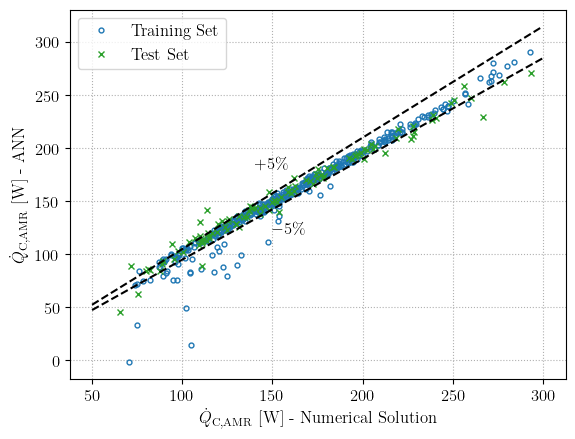

In [35]:
NeuNet(X_train,y_train,1500,'Qc')

In [ ]:
NeuNet(X_train,y_train,1000,'Wm')

### Testing the Models

### Reading the Input Parameteres 

In [14]:
Inputs = pd.read_excel('Data/Data_AMR.xlsx',index_col = 0, dtype=np.float32) # Input Data
X = Inputs[['W','H','f','mf','B','L','Th','Tc']]
y = Inputs[['Qc','Wm']]

### Train-Test Split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size = 0.2,
                                                    random_state = 42)  

### Scaling the Features

In [16]:
Scaller = joblib.load('Models/AMR_Scaler.pkl')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 8)                32        
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 69)                621       
                                                                 
 batch_normalization_1 (Batc  (None, 69)               276       
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 81)                5670      
                                                                 
 batch_normalization_2 (Batc  (None, 81)               324       
 hNormalization)                                                 
                                                        

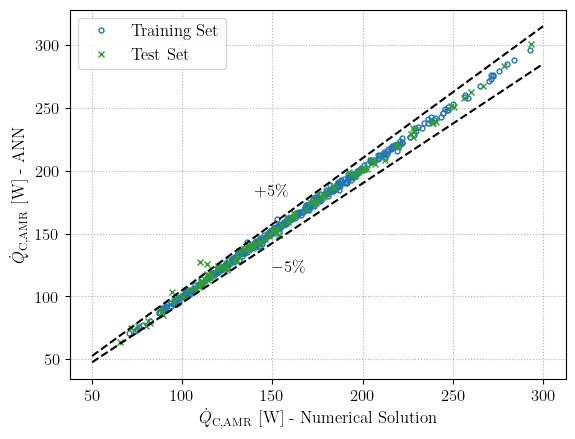

In [17]:
Test(X_train,y_train,'Qc',Scaller)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 8)                 32        
_________________________________________________________________
dense (Dense)                (None, 149)               1341      
_________________________________________________________________
batch_normalization_1 (Batch (None, 149)               596       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 150       
Total params: 2,119
Trainable params: 1,805
Non-trainable params: 314
_________________________________________________________________
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 8)                 32        
________________________________

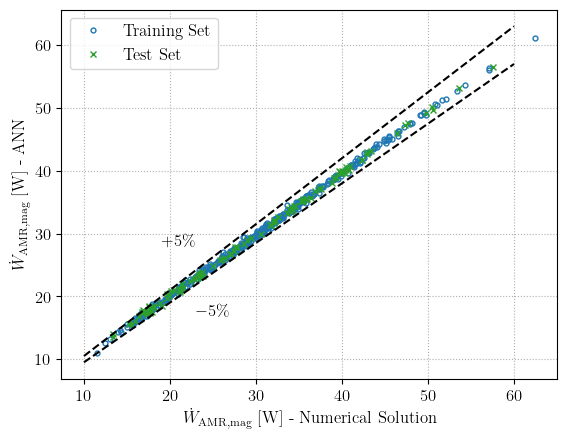

In [18]:
Test(X_train,y_train,'Wm',Scaller)

In [17]:
Test_lite(X_train,y_train,'Qc',Scaller)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 8)                 32        
_________________________________________________________________
dense (Dense)                (None, 69)                621       
_________________________________________________________________
batch_normalization_1 (Batch (None, 69)                276       
_________________________________________________________________
dense_1 (Dense)              (None, 81)                5670      
_________________________________________________________________
batch_normalization_2 (Batch (None, 81)                324       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 82        
Total params: 7,005
Trainable params: 6,689
Non-trainable params: 316
____________________________________________________

INFO:tensorflow:Assets written to: C:\Users\Guilherme\AppData\Local\Temp\tmppen0wavh\assets


ConverterError: c:\Users\Guilherme\Anaconda3\lib\site-packages\tensorflow\python\eager\def_function.py:1073:0: error: 'tf.Selu' op is neither a custom op nor a flex op
c:\Users\Guilherme\Anaconda3\lib\site-packages\tensorflow\python\eager\def_function.py:1167:0: note: called from
c:\Users\Guilherme\Anaconda3\lib\site-packages\tensorflow\lite\python\lite.py:804:0: note: called from
C:\Users\Guilherme\AppData\Local\Temp\ipykernel_968\1823064833.py:12:0: note: called from
C:\Users\Guilherme\AppData\Local\Temp\ipykernel_968\2695185997.py:1:0: note: called from
c:\Users\Guilherme\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3398:0: note: called from
c:\Users\Guilherme\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338:0: note: called from
c:\Users\Guilherme\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3135:0: note: called from
c:\Users\Guilherme\Anaconda3\lib\site-packages\IPython\core\async_helpers.py:129:0: note: called from
c:\Users\Guilherme\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2936:0: note: called from
c:\Users\Guilherme\Anaconda3\lib\site-packages\tensorflow\python\eager\def_function.py:1073:0: note: see current operation: %7 = "tf.Selu"(%6) {device = ""} : (tensor<?x81xf32>) -> tensor<?x81xf32>
c:\Users\Guilherme\Anaconda3\lib\site-packages\tensorflow\python\eager\def_function.py:1073:0: error: 'tf.Selu' op is neither a custom op nor a flex op
c:\Users\Guilherme\Anaconda3\lib\site-packages\tensorflow\python\eager\def_function.py:1167:0: note: called from
c:\Users\Guilherme\Anaconda3\lib\site-packages\tensorflow\lite\python\lite.py:804:0: note: called from
C:\Users\Guilherme\AppData\Local\Temp\ipykernel_968\1823064833.py:12:0: note: called from
C:\Users\Guilherme\AppData\Local\Temp\ipykernel_968\2695185997.py:1:0: note: called from
c:\Users\Guilherme\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3398:0: note: called from
c:\Users\Guilherme\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338:0: note: called from
c:\Users\Guilherme\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3135:0: note: called from
c:\Users\Guilherme\Anaconda3\lib\site-packages\IPython\core\async_helpers.py:129:0: note: called from
c:\Users\Guilherme\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2936:0: note: called from
c:\Users\Guilherme\Anaconda3\lib\site-packages\tensorflow\python\eager\def_function.py:1073:0: note: see current operation: %11 = "tf.Selu"(%10) {device = ""} : (tensor<?x1xf32>) -> tensor<?x1xf32>
<unknown>:0: error: failed while converting: 'main': Ops that can be supported by the flex runtime (enabled via setting the -emit-select-tf-ops flag):
	tf.Selu {device = ""}
<unknown>:0: note: see current operation: "func"() ( {
^bb0(%arg0: tensor<?x8xf32>):  // no predecessors
  %cst = "std.constant"() {value = dense<[0.335432023, 0.0780672952, 0.390895307, 0.236781582, -0.600180209, -0.0380164683, -1.0541364, -1.25908923, 1.24018228, 0.35125348, 6.264540e-01, -0.465615898, 0.233786821, -0.635399281, 0.212628052, -0.993162214, -0.946876227, -0.76163578, 0.278224438, -0.604293406, 1.01009488, 0.418545604, -1.10802317, 0.534350038, -0.509466529, -1.1552937, 1.32597136, 0.553846359, -0.450194985, 1.18388748, 0.108205341, -0.302530527, -1.21397614, -0.254754037, 1.472983, -1.29429364, -0.970553338, -0.243458852, -0.0883421301, -2.09605932, -0.126840785, 0.923274099, -0.543220282, 0.103401944, -0.911612868, -0.342210889, -1.08764839, 0.0493483357, -0.168832943, -0.854230225, 0.579991519, 0.517425418, -0.938437163, 0.68859452, 0.490870833, 1.24627042, -1.53976703, -0.681042969, -0.20618546, 0.948469161, 0.016793089, -0.286013901, 0.314382315, 0.60787046, -0.307261705, 0.251334935, 1.01070833, -0.867485702, -0.532846928]> : tensor<69xf32>} : () -> tensor<69xf32>
  %cst_0 = "std.constant"() {value = dense<[-0.852363825, -0.797546505, 0.461778492, 0.212146774, 0.0614570417, -1.06286645, -1.04847825, -0.979574859, -1.01331806, -1.0237577, 0.728898227, 0.418461531, -8.228110e-01, 0.20898293, 0.0897461176, -0.9107517, -0.999797761, -1.06018221, -0.811149954, -0.38048178, 0.180820778, 0.566372216, -1.12919927, 0.430921912, -0.361827314, 0.211873412, -0.908434689, -0.964726865, -0.850535571, 0.123883955, -0.944712162, -0.842413664, -0.882179081, -0.891183316, -0.97758007, -0.840769708, -0.103356898, -0.0753098503, -0.85086584, -1.01277745, 0.121359929, -0.768992125, -1.09406435, 0.224326462, 0.97309494, -0.995090723, 0.191147059, -1.02238715, -0.96523863, -1.02003276, -1.00714743, 0.0596312582, 0.123143658, -0.854443073, -0.0330768079, -0.907956421, -0.0452789366, 0.116604246, -8.498200e-03, -0.878096997, -0.94778192, 0.308992952, 8.679620e-02, -0.906478106, 0.125585452, 0.412126958, -0.492207587, 0.376824796, 0.171553299, -0.918304682, -0.874534904, 4.676800e-01, 0.261379272, -0.0238600094, -0.88001895, 0.197012886, -0.93989861, 0.323493958, 0.291887611, 0.128041059, -0.934776306]> : tensor<81xf32>} : () -> tensor<81xf32>
  %cst_1 = "std.constant"() {value = dense<9.358670e-01> : tensor<1xf32>} : () -> tensor<1xf32>
  %cst_2 = "std.constant"() {value = dense<[0.887926936, 1.06402838, 1.42036891, 1.40668845, 1.1146642, 0.960994422, 0.659228861, 0.609884798]> : tensor<8xf32>} : () -> tensor<8xf32>
  %cst_3 = "std.constant"() {value = dense<[1.42505634, 1.651700e+00, 0.120898657, 1.29313362, 1.45542538, 1.76798391, 1.00111163, -0.44931227]> : tensor<8xf32>} : () -> tensor<8xf32>
  %cst_4 = "std.constant"() {value = dense<[7.84861946, 8.11364936, 13.6886063, 6.12053156, 6.73389101, 8.27385902, 12.1785774, 15.6334305, 8.0676012, 5.45804119, 5.97810173, 7.22191619, 6.24633026, 8.46934223, 8.2059164, 6.21356392, 5.604930e+00, 11.7528944, 10.3628082, 6.73726749, 13.5957756, 9.55128479, 7.67183542, 4.84012079, 7.54695463, 12.834444, 6.67557669, 7.34182882, 5.51999474, 9.82894611, 4.13603306, 7.69203329, 8.54062271, 4.46236897, 7.44660186, 17.6785145, 16.5711098, 4.38495731, 5.53807068, 13.8107214, 7.61165667, 11.2780895, 4.89931536, 5.66172504, 10.6689939, 5.43190908, 17.0482731, 5.90989494, 3.53303695, 6.22218418, 8.15379905, 7.64665317, 5.42490768, 7.87835455, 9.86061096, 8.56848239, 17.197403, 7.45806407, 5.85579824, 15.536128, 5.05549049, 6.62597704, 7.14973545, 8.84400177, 9.926054, 11.3867512, 6.02506828, 11.2565298, 8.15592098]> : tensor<69xf32>} : () -> tensor<69xf32>
  %cst_5 = "std.constant"() {value = dense<[-3.07496738, -5.75333643, -11.4885864, -4.77737474, -1.90911889, -7.52397394, -1.68824887, -2.18783569, -6.54859352, -2.802200e+00, -2.66863823, -5.42112398, -2.73149538, -2.2274394, -5.92259598, -2.77677107, -2.94199824, -3.13636255, -8.12991809, -3.16786861, -11.3606749, -5.70907259, -0.142946482, -2.17775822, -2.38775158, -1.77945018, -3.61963964, -4.1500206, -3.038320e+00, -6.910990e+00, -3.36353111, -2.46837592, -1.41818213, -2.75960255, -5.54095364, -1.30122721, -1.99179268, 0.0358792543, -4.25475883, -2.0159955, -0.930238604, -8.55771541, -0.0982115864, -3.22896147, -2.65573359, -2.4767642, -1.52353048, -1.948760e+00, -8.361510e-01, -2.59700727, -8.23731803, -6.1550765, -2.27180672, -6.80731392, -9.026762, -5.64080477, -2.39957476, -2.44514918, -2.57742333, -13.7066603, -2.72960091, -4.88920879, -3.64635134, -6.2218647, -2.27186823, -11.4823236, -2.96497631, -1.95277786, -3.18800902]> : tensor<69xf32>} : () -> tensor<69xf32>
  %cst_6 = "std.constant"() {value = dense<[60.6080208, 62.127533, 1.05215836, 1.10175419, 0.995514094, 64.7999114, 66.5898056, 64.2259063, 65.5609436, 62.3090401, 1.13551927, 1.03632653, 61.5939445, 1.47308588, 0.937709867, 62.0953941, 63.7878189, 66.7713318, 6.616760e+01, 1.60349417, 0.976441979, 1.03731871, 67.7628555, 1.04402769, 11.5023746, 1.29481494, 64.3077087, 68.0640411, 64.4939499, 0.857703149, 61.9408569, 61.9263191, 62.1951256, 6.051270e+01, 62.2173919, 65.2660904, 2.26031327, 1.96130586, 60.3177642, 66.3018875, 1.22369146, 63.1279907, 63.0544624, 1.02124274, 1.26397812, 62.4566383, 1.7829206, 63.2790565, 6.709700e+01, 66.5307769, 65.2896881, 1.77894831, 1.74784517, 62.081459, 2.60771298, 60.9436492, 3.66614509, 1.62861192, 1.71649897, 60.8170967, 61.1309661, 1.46926486, 1.86691439, 60.8179588, 2.77909923, 1.0169673, 8.12161064, 1.01618767, 1.1879735, 62.7745171, 63.5586929, 0.955084919, 0.979909539, 1.31727314, 61.5312614, 3.06670022, 62.7958069, 1.10324955, 1.93915558, 1.02637553, 63.6279564]> : tensor<81xf32>} : () -> tensor<81xf32>
  %cst_7 = "std.constant"() {value = dense<[105.184914, 107.774124, -3.77030897, -3.08547974, -1.02562749, 112.377586, 115.465034, 111.391785, 113.69017, 108.092239, -4.01363516, -2.48811531, 106.886444, 0.487039804, -2.0731082, 107.732735, 110.649788, 115.779099, 114.737885, 2.85074782, -1.64674735, -3.0904932, 117.428909, -2.91059971, 20.1903038, -1.65562594, 111.533531, 118.004082, 111.875389, -0.747783422, 107.466583, 107.436325, 107.915428, 105.002701, 107.960075, 113.180977, 3.5875349, -0.781137466, 104.677429, 114.967659, 1.42210269, 109.510849, 109.371933, 0.334907889, -3.97877884, 108.357132, -2.04970741, 109.757561, 116.33654, 115.354507, 113.220795, -0.408884048, -1.87672818, 107.701706, -0.0274068117, 105.751358, -0.824559211, 2.02094173, -2.01402044, 105.537971, 106.076469, -2.09267807, -0.596788406, 105.540489, -1.39015758, -2.61054611, 14.4892731, -1.30099165, -2.20590401, 108.934425, 110.246307, -2.48842931, -2.61362743, -1.12672496, 106.78685, 0.178420901, 108.922127, -1.22638357, -0.277497053, -1.70466924, 110.372826]> : tensor<81xf32>} : () -> tensor<81xf32>
  %cst_8 = "std.constant"() {value = dense<"0xC95780BDD72AAA3DA0A0623E124247BE3039A5BD866809BE4803C13EFFE53EBE1F6DB13D6F38D73EA4DD5FBDF18C0D3FF65CB43EA2F7583EC3168CBEA7978C3BC6BE043D0CA99A3EA5555FBD81300F3FF5AFFA3EC759913E141C723D36B0E1BDE482F7BD10D46E3E4127693EDCEFEA3D89EFF93DAD4886BDA1FBAD3D0A51A8BE370DEC3DDBD38C3EE071A63CB248463EB1A036BDDAB5F4BDA23731BEE907013EE8F26EBC8BA512BDC386A93CF2D5FF3DA2B4683E9843103F3C1545BD82DAFA3D65B295BE9E508BBE907FDBBEDA3483BE883488BE37CD92BC285453BE3B60AE3D8D91DEBD2FB04EBD478108BD7327F3BD45BC64BE66C54DBEB8D860BE94B4DCBDBBF8443D12DA4EBE9CC4DA3EA9D4DB3D3CB45A3E00A8943D509D093EC98B273D9538A5BDF926353E59474ABEB998953E49A74A3E5A3092BE3DB96CBD90C35FBC04A7BE3CC0E97ABE8D32943D107EEE3EA55C88BDE5BCACBD96CE13BE21906C3D2AE935BE152F44BD486135BD5897643EF3F7823E13DE8C3E4210FA3D5BB93B3E67EFB53D6FA1C9BDDDED863EFDAA873E5F79853E40C374BE1A62AC3BD56A553E5C3EAF3C7A183C3EA2366C3D0464EE3D395BAE3D4F7E39BD3D07B9BE1FD2F93D5219AE3EA7E3AD3C8FD9AFBDBA71D03EFADB713E1894A43E0A1F52BD7410B3BD0FCB1BBCE686003EF4CC2B3DFA6E03BF6DA1B73D33F8853E42298DBD3919803E804B04BE577220BEFE8A3D3ED515C33E30A9DCBD48ABA23CDF3FCA3D6B0865BE26DF66BE01BF87BE9178823DE228C93CE91B7E3C01B391BDFEE2833E36A574BD6AECEF3ED97DD43DD1CDEF3D4A9C1C3E05CF593EEBEE2C3E7E603A3E9384BF3E1999EB3C79357EBE6C29613EEBAFBABCF29FDA3DA6D48B3DC39E6CBEE88880BE4DD8233CED12EE3D250D6ABD88AAE33B0163F23EF169533ED0C0983CBF88503DB5333CBDBE045D3CD87F9B3D7062CD3A5D08DD3E7402F3BCD92A11BEC05FE3BBF0A7DC3B7177AF3E194E2E3E7988B1BE4B1ACCBE2BEF523D8EE7A6BE6749B3BCADCC90BD76B957BD414C18BFC3FCFF3D7DC706BE7288003ED95508BEA37C04BEFDFC0FBEC71E98BEE2D326BE40A9FDBE74F6D7BED656003E9B6E293E7FC1BDBE0115A5BDAEC149BE34700F3E38D876BEBA2DD4BE99E148BE43B024BE05CB2ABED1048BBECDD793BED4A690BDBEED1D3D63BC0E3E272E2A3D1141773E3DD4F13C44F9E43C3FAB1B3D1F53E03A808970BEF1AD7BBE0B222A3DAF9092BD71198ABECA1ADD3CCE520F3E71FD3E3E69A8BEBEA1727BBE6077BC3EEB3766BDDE3AB23DB3AC953E3884973E75D0253E1C6869BEB1D62C3EF6A246BE0484DDBD6DE4763E19DC9E3E558B30BE0FD9F53E355230BEEE169DBE6068973D77E1AE3E9B268ABE3067223E9896A63D8C804E3DEE294E39F5DEB4BEF14C28BD3C591D3E95465A3ED5D7D8BD8E29A33DA4B7B73E1853BCBE77A33A3E0824E6BCD50E35BE8CF1063D0AC74B3E38E9E0BE99361CBE1C0FBCBECE214E3E1D2C573E96C6713D4D5AC23C55A56BBDAA1C2DBE3DBF83BD0276803F2C6804BD2089DB3C170CC03C2493D2BDC935C2BC815660BEBDA137BE3C7015BF0A45CBBE9A91C6BE204188BECE44213ED07F69BE117797BEFF66263EE2A4A2BD229B19BE40B5B0BE9C6736BEE58057BE9BDE23BE746F3BBE223C2A3E066D123D32F99B3D3FD321BE4716E93DE5CCAC3E6EA0123E422E9E3E94AF7F3D98FD353DB796D9BC357E3CBDECAB1FBEDCE6E03EF98586BEAC68AABE5F0C3EBF432CAE3E72EF363D92FC90BE68761F3DFF75F6BD821CC5BEF11D07BECBAE0F3E98CAA13CAA006DBEBF72183E67DC6FBDAC8D90BD0100EC3DBCD4E3BD4AFB56BE44480ABDDEA63C3E7BEFD33E77D27BBD954A073E09DC5FBD00C201BD58F973BE4D71CABED68D1EBE0D2E4A3EAFCFE4BEF9AE8BBE851633BCB0F808BEBA619ABE903C983C186A0B3FE022453EC0693B3A08C1BE3D70ADC7BE387A6D3D4BC99E3D3B33163A6F1AF4BD7C25BCBD137411BD651EBEBC4F10483E28A80FBE98CB0B3DDB13EABE7FD9DD3C45AFDB3C16E485BECCDC40BE7AF5ACBCC284C6BE3088203E64771ABF3F1E03BFD0CE8ABE15A8213D8198D83DFF4A043EA84D24BF4F3C03BE7F0488BDF8A5F73DA730A1BE6D613C3D5C55DC3D91D5183EF6A88B3D582329BF561D2F3DAAA2243E0C338CBCC74589BD9872A0BD38E747BEA4A08D3E1A2209BE094598BDBB4E7CBD9E30213E1708673DC62F8C3EB7E4CA3E2D2D873E574758BE3292763EB22D083E427056BEEA8CDD3D1F6B2EBD97A212BEA998223D0669D4BD5AD81F3E7EB9AB3D05FCB03E17E976BE9F91CD3D764DFB3DAC85BCBCD418C63C28B213BF7A1BA43C223C283EDB3D03BEFB708E3D855750BDC2A4C0BD32458BBC3B0BB03E871309BC96C0863CDD34CF3BD19611BCC394EA3E9266963E690BDDBDE5E9BB3E5046303DC496B53B0EA018BDD406C23E8CE86F3E8DC62C3D3367D33D1F4253BEB3B40C3EC24F80BE288286BD9DBA0B3D5027A8BE7FAC03BF32A1313CC442B03E493C70BE41F66FBEB479883EAEDF21BE8555C03D16A58EBE057A50BEAE21593EC656D7BE4D1FE33D1E6CA0BD5C529EBC227091BE0BE3813E32C00E3D049D4BBEB76F88BE4F62363E2F25E6BDB44998BEB50FBB3D6BB2B43E5A6626BE7A778F3EB1B1F33DE53AA93E2360643E148FBABEA955EDBDD510123D44D1FB3EEFBE1FBD627FA4BE2683A13D3F22F4BCF2DE0DBDDC14EEBD301D053E67CC5D3D79490DBD6D310A3FD362E2BD87846C3D5384063EFE1F093FE4BE06BD7ECC0BBDFFD8233EE10031BEFA9A093D9185F03CC2B45B3E6098EA3CF504193D4882143DB46896BD2CB113BDE6B2213F5D0B4A3C806B383D4BFF90BEF770CFBDE3E995BD1FC7A7BE2F6EC9BEA03501BE2F8FD2BE736F733DFEB2CC3E977FBE3E0E471D3DB122823ECA84833D32DA5E3E27BC213DAF13BB3D6A181CBEBBE04BBEFB6F1BBD89C8E73E599B4EBEB65E3ABD0824223E8BEEA3BC4A1990BEC1D239BE961A72BEBBF6A5BE49FB65BEC7D5EFBD6829A5BE9DD8F93D305367BD11FAE6BE26B204BDB49ACE3DB0FA01BE2F66253EBCD5A93D19786ABE"> : tensor<69x8xf32>} : () -> tensor<69x8xf32>
  %cst_9 = "std.constant"() {value = dense<"0x4B208EBE8ACA2FBE954ECBBEC3CA7C3E1AF69EBEE1FDB93E215EF03D4A93893D1BA5B53C662333BEBFD685BEE149C83EA7304FBEDDFC30BDADC551BE3C9AA33DA733A63E4487453EC89D073DDDBB4B3ECEADB33D1D349ABEF8F0AABEAC4867BE492F0E3E518E4EBDB3B832BED715113C39C73E3D2ACCBABEB7D8A23C873C17BE1E9579BE3DE3F4BC1E409EBE57DD0E3E0A64903E4A2684BE0B50353E84624A3E5BCFBFBE2393C53D706F9BBE8859AABE3066993EB173173EDB05273E574AC9BDF3FE6EBEA5916BBD3C9FCD3EF8BB943DAF02833E2767053FF503AA3EC30026BC333F923EA3AD773E490A553DDE9609BE57F4C5BAE999B53EF3FA08BE1E9CD7BD7D44B63E3B3DB33E9B13B6BED98EA13E2070E23DFA6FABBE62F484BB06039ABE191B3B3E962574BDAA6DA23ED31D233E250054BCCB1EF7BCC14B11BD7BCB96BD06E0A23EE6CC5EBE09F3BFBC51F015BE62ECED3D34B8AF3ED1AB313EC54C9DBD90A0C63D302C69BEF1B48FBEDBB960BE0FD1B3BE0454403E24CE693DF1B903BE515CD2BDF6A69C3E6AA0C4BED9D7CB3C3CF246BE47C543BE9FF7B83EA74F75BEF32DFB390EE5493E95C763BEF3735F3E178DA73E9EB988BE65DB25BE491BBFBE20ED1DBEA192843D2BADB33E607E173EC6F7CBBC645C46BEBF5A4A3E416DD93E3972143E1F03B03B4E9DC53EDD265F3EE17074BE05CA6E3E809DA0BDC36D13BEE2B095BEA90B693EEAA77F3EB5DCCDBE1DF708BEF64BF63DF537F83EB7E6CFBE424BA13EAC42C33DC65AA0BDC7C3EFBCDC68593E9FC807BE1D9E80BD77FD5ABD824F98BDEDBBDCBC670F833DD4B5BF3CE686A53DE487C63D0DDF963DC170433E1226A53E5E9F31BE0287C63D411570BE91B1403EF4BDCEBA6E33A13DDC99A0BDE41DA23CAFF32E3EC27F78BE1A60F7BD126828BDB0278D3DBF3A21BE94F1F63D98D413BEFC48563D603C06BE9478F9BD423A6B3E7950DFBD709685BE6454B4BD6396BABD0C6C50BE1242343EE33ACEBD300A383C9F328C3D0D8D2C3CCF14B53D4A9D0CBE1161653D765D53BDAF910E3E21620CBEB020B2BDBC4E72BEEAC407B9EA5127BD5972143E581E0CBEABBFD6BD0C589CBD0546C83D5F90123D3E2F293D8A9C35BD13626B3E09A18ABDCE17383D13823BBDCF821DBE72BFCDBD16BB083DA893D33D32F6D33D853EBD3B998AE3BDB654753D086AA73CBAA1E6BD8B11D33D6DD19A3C95383E3EFD3D37BE9C6E3DBDE1446C3E02070E3E2A3509BD74950B3D28FAEE3D2085883EFF7FD4BD02C1EA3DD9DBBA3E493E24BE742D963D246638BED5A481BE231AA93D0BB0953C45C30F3D4122293E8B6CC6BDC2084BBECAFA9E3D0811AEBD21EE6C3D5DD98DBBC7A8E73D9B91EBBC7133BABDB74441BE9BFDA73C7D4BA03C73C98F3D5D848C3E3E2602BE0CC4723C70CABBBC04F4933D08D49D3D84B19B3D9DC22BBEF9B972BDEC1972BE16B8223CDC0D35BEB081533DF70CABBD715D0FBE5126593D1CFF923DFA41E6BDD560373D233806BE43E7843DFD506E3C30D6B93D00DD3EBDDBE22ABE257F0E3DC3A8DD3D8B6B5FBE389080BE859A2BBE7808133EEC7EEDBDEA60ED3C3257763DB7AEABBD9FAE40BDD6A25C3E33420D3EE808C93D7A3D193E63D9BF3DD710A8BED4CCB83D4AC1223D893134BE8434D9BDDFFB21BE75CEE5BDA3AF42BE39F08C3CDC8E25BD8623453CAEB5873C59874DBE1708D2BCC3FE18BDE93C66BE5BF6393D5AB6B6BD91578CBD25B8A13E097F93BD61ACC5BC37A1233E4E7069BDD9CF8DBEC503073EC33F073E409EA2BD739938BCEFC0F0BDD9557FBECEB039BE8892C6BDD72CDCBC187B69BDDCF3253ED2EF733DEE8110BE8331583EE37B173ECB07A93D12DB81BBAA7B0A3EEB29F3BD521FC63B42A487BD0048A4BD8F360C3E119864BD1E7A35BEBA042EBE02C5513D61B9D63C5E1F14BD9925E8BE488682BEED0790BE6C284A3C13F9C13BF8709D3EEE5C1A3EC7F16D3EAFE78EBD04ACE4BA11768CBEBE14123F67E29CBE49778CBEFA1C92BE2C792E3DCEBD073FD7B6853DBADB3DBE895D683D72615DBED23DC2BD4DC694BE2F106DBE5716513E522ADD3C7E4697BEDA76553D90EA583EAA8CB3BEB158043ED51B9FBED5CBBF3BEEE9663D36567CBD31C9443CBB9610BD7B7E6FBE6ED88F3D380F073EAB82C0BE8C086EBE3C7BAFBE218C8CBEF402033E8B32183D68D7AC3E471C343DB015A1BEA697423E3802E43E3348B83DD649B43E98168C3E9557903E6B0B15BE2371E23BC647833E92D2A8BDF40D86BE5ABDB8BD46B3D53E6CFCCEBEB85CFCBC96D7433EE5EF803ECDA435BEB90C933DF788B43EAF3543BE48B19EBEA836D2BE93592F3E91FC53BDC719CD3E8883A63DF753AC3E93D6FA3D0387153CA0B0D9BD4B1CCC3EC191BEBE4F806DBE25A2A3BE81E0B43E6ABEB83E528E413DF4C0EEBDE141A63ECD2B80BE5AC4ABBD04F218BE75A46DBE10C3443E47FE273E0AA0ABBE332ACBBD2CAD403D01DC4FBEF9CB903B1EF729BE17D7DBBDC673113E4078A8BD3D6D253EF3C40CBA4DD6D6BEEBF8FC3D8F79BE3E060694BE24E265BE0155E0BDE03A78BCB68F8B3DC10D5E3DE7E3903E8B9E553D1F6611BE73C5203BCB888F3E6A5BA13E01DE9C3D4CFFE33EBEDD5B3E70228CBEFD28813E061DA0BD5B1A463D8573A03C9E0B143E0615DA3EDAB674BE7A1439BE9F81F43D4E71F63E65E7A9BEFB97C93EBF5C853E067BD9BEF3FC9ABD169F82BE7415753EB22C4ABE7B62F83EC3890C3DB455993E08D50EBE338C9A3AC674C6BD7795673E0F3C89BE4A7684BE7D05E0BD016B093E2F60943E6C3258BD243E50BEA4B6893D4E1012BDC2586DBE61FB11BE1CDCA2BE0080763EF5136B3EBC1D5ABEE4D262BEE76B23BD9ADC7ABEEB7A983E7F8F5CBE9EF493BE6D63AB3EC0A16ABDEC35583EF2981F3EAC8091BE4BB0303EF2CFA53EC0E794BE90B670BD43DABCBEEE317ABE031BA63E49B8163E282EBA3E8BA5D13DC3F473BEEA84E63D01540D3FD1C2AF3E7E7F243EE620CD3E09A8CF3C1CD520BEBEA8073E819A8BBD9919593E6660BABD1A8CAF3D738BAD3EFBB52FBE11A196BD5CD7893EA224893ED669A8BE4B93B73DB3FD7F3E4653BBBE9CCF9FBEBF2409BFDFF55C3EC1E983BD8614CA3E1DEF123E5ECDD33E7E5698BC531583BCE75589BE6A2DCF3E4CF393BED78EC1BEDCD32DBEBB3FF93C9A97F33E1E4BED3D8459D5BEA88FC63DF25EF1BDAAF77FBDE1AAA2BEDE5F6A3B156C933EBAB7EE3D977874BD3DBA863D0DEE8D3DFA35A2BE51169E3EDB9F4BBEA314C6BE75D4D4BCB442D8BDF138E93EBCA396BD423AD3BEA18F953E13A0383E318A74BEE59F323C4C2E6FBD5A22FEBD2DA15E3E3C25993E0BB1AB3EA376153E556CA4BE3B760B3E0A5FAA3E91CEBBBCD5B7143EE584EA3E583328BB644893BD8C7CEC3BE16F993D3EBC383E0C7EBDBE962CFDBD83A22A3E749153BEEA1DCFBDFDD53E3E670B873E5C2872BE5C95B53E7A18143D8161F5BEAA9604BE5917CBBD9567813E2A6F97BD5CE6CF3EEF8E0A3EF592433C111B803D40A6153E67C42ABE80C0E33EAECDC7BE43104DBD570E8DBE88B7B63D48A4AF3E0872AA3E409BC5BC0A84AC3D14A61ABBF3A8833DE59FF8BE5B242BBEED4B803E8D8FD03D694635BE4C99FB3DAB33833E6144EDBD0B5F8E3E1CBA9E3C5B6858BE07C24F3EF91A2DBE167F7C3E554C543E188FE3BD92C24B3EE0E5B53E08F6D0BEE825ACBE3BA61DBE65C14E3D5CF5D33D0B87203EB1F4903E452912BE298069BE3E97B03D0FEBA33E8A7A023E37FD8D3E27A6C33E48847D3E4900CFBDC43A7E3E5E163CBDFC4C3F3ED240C2BB2C821C3E2633823EE5120CBEF9FEA4BE7BAE943E0C1D773E6C5B8FBE23F0803E7880533E73796D3E3331713E4076BA3DF5459CBDE7EC0F3DF79C993D25B971BD31D769BE1EA3FBBBBF26543EC6762D3E94D23FBEA0AF24BE6DFBEABC22CC393E78B261BEC379DEBDC36732BE0BD5213DDF31E6BD272A61BD50B4033ED93A003DED963ABD177C53BE212F19BE65102CBE9EB55D3E4678EABD823DB7BD840F063DF8BAA8BD3E13793DCFA72EBE73B1763E391E9FBD8C39F4BDC34B6C3DA9AA07BE23CEDABD9EE1E4BD50041F3E40C809BEFE5DBB3A650A28BE90EEB3BD7ED220BC090F26BCC2280EBD1B9C033D50D6433EB123063CAFBAAC3DBC35F2BCCDA00FBED0CC273DE4866EBC27601DBE756D0F3EAD8F4C3E7225C53D9961B63D27AC553CF3AE013E4EC2CCBB0ECC5DBA8202233E3DAC4FBE543315BE781014BE05749ABC7CE189BD885763BD7546403D19F90CBE0736943D2A2056BE863A093DEB10DDBCAA8A303EE61B3C3D2EA47F3E519A313E8D17723EA1C863BD94F6F8BD7090DFBDF3E2313ED42A4FBCBCF3F43D8817C53D78705B3D67290DBE794837BE00CB3CBB0B2AB9BD7ED686BD64508D3D134125BE0242EEBD5FE2783C142CFCBDB37D32BECC16B23E81CE63BD274E373D39C56D3B52A5C6BD145E0A3AF8B9173E9FF00DBE918031BDCD1FED3C43F1C8BDFC5E5E3DBB8E21BE8BBC003D7453C7BDD2168D3D677B973D39F621BD6DB62BBEC2447B3CDF52033EDDF78CBD9C85BABD523446BDF2526DBDBB5FFA3DBBBB713D035D0A3DBF746A3D2E1FE03DE5C4A6BEBC0AD6BD231E3A3E598C5DBDF3E46FBCDE58A3BE82CF223D69C2C4BEE3898C3EE8E095BE9F2B8D3ED78CF03D5A4A99BCD37FB0BD3EEA04BE879F11BE308AC13E3A7E77BD95D1C2BEB6A285BEF885AD3D8FD28F3E7F780EBA3E9E7CBEA108303DF55B31BEA117233D2CAC99BE3BBCC9BD2E7C10BD4159BD3DD3E554BEDCD597BD375C813E09ECA1BEBD84DE3DC5BB8B3C719448BD369B6A3E744B94BECC4D163E45B98E3E2F4BEEBD2B44923EE9C1873E359FC8BE61FAFCBD5C5D18BE010EE7BD189C1E3E74F25D3E62E8423E382D33BDB84EC2BE9397B4BD283F013F41DA453ED002853E3FD3113F0A92943E4D1B73BE0A09493E52B5BA3D4B76373E9E572FBE2F74083CDEAF493E9486AABEAE0A77BE5791993E70BBE23E45A382BE556F363D0618903E98847E3DA9CCABBEBF6C12BEB0068A3EC450603E65A0BDBD48643FBED8C123BE4CD0C83DC16035BE3A1360BDBFCE1D3E23A2823DC92408BE7DE504BE8A58D5BDB1D63DBCB274A6BD1CBD8BBC453530BDEB0D813D674E4E3EA036613DB525343B6095C1BC2D53773EBD4B133D6BA3533DC717473D97AF273D88A438BC1A3B7DBC3E8915BD8BB4CBBCFD4115BE45CC293ECC5E45BD337057BEF993B0BD897F6CBE257BFEBC9C10B23A3B19143D176E1F3E53DA02BE05F38E3DEED528BEB91BD9BCCE2435BEE33740BED63E0A3E0CE2373CCA5E1D3EB9CBCBBD436BEDBD508E5C3D97F8BCBEFBA3DABD2C78A13BE1C6CC3D0FB2DDBDA015743ECE2E863EDB7DC83D78F8B4BD5295BA3DEAE194BDCA270A3D6563073D2217B3BC5AFD443EB2B0573E0AB5963DF6851C3EB06C94BD81BBAEBC9AF5303D11A7A3BD409C22BE1EF4C63DBF2A56BDBC770ABE70AC563E9BA1723E4F09E2BCB329F33D44F1633DD5384F3DA953EF3D553F983E459EA73D8737DEBC5CEC4D3E05C5A4BEB4B7C4BB3E91853DE85934BDD702AABC5A6A503E4B1A30BE55A06FBDA5FD8FBD7756883D12D5BF3D3AC3DA3C55AA073DB8ECCD3CF87C763EF5478BBE3A602CBDFA120C3B1F5B113EC85AA6BD6CF7893DFF6A38BC01ED70BE932324BE6C7C423EBE438F3E1D757ABC1A53383DDAE945BCB3248BBD5AFE8C3DD0054F3DAA11D73DD13FB6BD81A8843DA7351B3E685541BE2612AA3D4FE1833E3485A33D95DE7DBE57F6A43DC8F7753D4185DD3CC84540BE941192BE67E49A3D9322CFBDC0914D3EE1E8FABD114DA53E450958BC1417A83E3A2D22BE21E1053E95E06EBEF8CDEA3E39CAA6BEE75A5BBE93E58CBE75EE6B3ED13BA13EE3D4233EBFF0B9BD6421983E8D3B91BEB18A1D3D1C33ADBE79B59ABE18BF4D3E51CE4A3EB97E87BDE182F1BC233B8C3EE48699BE7969333E688DB3BD81F434BEC72B4B3E63A51BBE34CA1F3EC78A733EE8136BBEBC44B03EDAB69E3EB5A003BEEEB86ABE10785CBE82AA823D4414F13D726A383E9294893EEB45733E38616BBE7C2A693E42F3553E92FF4B3DC389373EBDAF893EBBF8BC3EEA7FBDBEA9CB403EE9305E3E62DCAD3DBD0AFF3CEB49053E011EEC3E275C9EBE99C63CBEBFAE9C3E4DB2C43ECC40C6BEB6B77EBCD11CD13C24CEC4BED7523DBE3FE34EBD10AFAD3DEF499CBE9151A03E09037D3E63AA9C3DF89F83BD96F627BE37FCCFBE77669F3E63BFA8BE3A49E7BD5252FABD605D503DDD1D993E0203963E734A09BC7140733E8DA99EBD224722BDD3774ABE94BD7BBEAA8F903D0CF5873E3918F9BD914A903D82D53ABD044267BEA5BE163EAE0401BD2C3FEBBD16DEA03E59D196BD48CF543E5D0772BDC2E5DBBE2ACE2D3EE097BE3EF5D2CABE5299CDBD6A92A6BE75C631BE66EEC33D035C1C3D6AFC783E99BC52BD2FCA94BEB845353E320B8F3EE35DC23D5F3BA03DC91A873EFE1B133E1F2ADBBD5058BC3E5F9C7FBD7DAB9A3D7AF693BE1346733E3213393ECE0F04BFC804BEBEFE5E573E7C22203FFF51D7BD1F4AD23EB43AC13D9053B7BE51BDA7BE9A529ABE852E333D58A5933BFE51E63EDE54FB3D9021073E445886BEF404033C517898BE28C56E3E417DDCBE547464BD0480AEBE81506E3EBC0D6E3E96A7783E71A932BDF42E893EC513793CE9282ABE7B3B07BE6AF73DBEAF2300BD4033FF3C635776BEBFFB36BDFDB0163ED0DBD5BE51A6B33EC5F8AC3DB2A9C0BC1D7BBD3D3EB747BE5DC69C3D9020463ED32E75BE14E9413DDB77763ED25A24BEB1D166BC808673BE7349B4BCBA0C8C3EA638AC3E936A8F3E1A2B173E751CEFBE59D9D03D805A193F5482513E28EB313ED2AE0C3F6AAE073E3E6626BE7BB8BD3E021DFE3C8EAC273EAED49DBD2DA7CA3CD21DE83E0B66A4BE0EA9A4BED3EDAB3D787A0E3F7A942EBEE584AB3E7C2B423E731D93BEF41EAEBE33C2B5BE5961993D6DDCBEBD4D41053FA583D03D6C07033E1EE9403E7124B43D514320BE6E63C13ED447DBBEE405A8BE6705F43B57AE153E7D0F983E2D19433D5EC476BDC198053E6C034CBE48CBE1BCDBE7A5BEECD089BE09B2C6BCB70C1F3ED4123EBEECEE383E71D3423D20EAA9BE33F2A73E0E587EBE3A4D21BEF1DBA03D54AA78BE5D409A3E9BD3D33B5B94ADBE9D485A3E81DD9A3E5ABF72BEE6427EBEF3EFCDBEBD89A2BE393CC13DD012963E4C55FC3D01E8EFBDD319B7BD97E05C3D1409C23E3A399C3EE598533E0878E53E37E8C73D3649A7BE66CFA33EDA8D3DBD4A13A53D955643BEDE329F3DE428913E5D91C1BEB4F90EBECBDF8A3E7295B53EAB67A3BEA9AB993E2BE8AD3C40BB44BA747826BE2063D1BD9BDBADBDB2865C3D1923383DCB2C4A3D82088D3A0AC20E3E08B793BC5CF31F3EE53080BCABD794BD7B06003E9140ECBDC0E5F73CA69D163D1F70BA3D818C293EBC7CA2BDA1CBD63DD4ACF93DFD618D3E70E32FBE2A5B843C6BA56D3E9EC00CBE246FC1BD9894B53E02938B3DA3D89B3EA2D41A3E69A0D7BCAB0E7EBC5D81673D24BABFBDD8DCC6BD37D1523DB316093E9D980DBE48F1963D49E5BCBE9C67053E0B888BBEFA05413D122C423EC83572BED69C98BE818ED2BE9340F4BD388B51BDB5A5243D851A42BD0E8CAE3D275E1CBE9B8FD6BD4773FA3D42565CBE285B113D5600D8BD1995B43EC20BCABD6E9603BEBE4B373E9793303DF1C7E83DCF2F9A3CC907193E03FB0C3C009F1C3E70FAC63D5E627BBE795BABBDC124623E2C9D40BDADEDC6BD5AE4A3BCF6FB3BBDA268FE3DF6A62F3DB3C5463E27D33D3E192E89BDE5C87C3EAB00A5BDD00AB4BCA68D30BE6B495E3D1BDED53BDBE9E33D24A4613E364DBC3D1BBC023D61FF3FBEEDA4343D177E593DE3724DBEDF8A323D11A0043BEF30B2BC5541DD3D713393BE848CCCBD524F783E00CD4FBE3B6BE5BDE406513D03779A3D4220EC3C65D197BDAE3D9ABD633FD93D6535BBBD40B7A7BC2BC3D0BDFE082DBEE860AD3DF873AE3D8E6812BE448703BE5B59583E98D061BDC5D2533E6054D93DAC4A65BE5565C0BDA56CB7BD188EF5BD9B6285BDAA9FA33D4BEBADBD49EE653C0215263E7BF388BEE55544BDBD39BE3D9169503D2C67063E7F7DB2BD05F19C3ECE3F743C68C3153E2993903EC344B03D4141B8BD788B593C385CA13D16A2183BE373B83D17500CBE33A9DABDDB16DE3D94AE073E4EDE80BC68DD37BE2262F73D71CD493E1F97E6BD01511F3E0A7514BDEA78483E73E2303E32E648BE83BB82BE3B0BF63C613A04BEE6E174BD0300B93D04AEB4BD875E2FBE5567DEBD4BDED73CCCB6BA3E43EB90BE6C43043E755EA3BC688D313D8EFA1CBE141261BBF6A4E6BD392494BDBF257C3D5AC023BED1551EBE79D7983862F06DBEDDEDA93D9649C5BDD50B143D5892173E2AC896BD52E593BC90F2F7BC2CBE333E90ECC03D85B3A9BDF69793BDA82EC8BDF0BB813D76BA15BDC5E2BDBC18BB7E3EF80B36BE19C340BC69B681BDBC1975BDB86DDF3CCA6B8BBEC42128BD8401E4BE7A5C7C3E7F16FCBDB933D03E83E3733ECC3F333D4FD4EDBDEF4247BE63F73DBE188DBA3ECF6AD2BEB3E5E83BD315A9BE800EE43EABF8EF3EF6CC903E93A92BBE0DA7943E8CACA4BD7EC66FBEF4C4A6BEEFE3A0BDE1CD753EAD035C3EB67780BEDE39A1BC1BA21C3D49E957BE52DEB23EBE948DBD8B1F90BD81837A3D00DCA0BEC9B2413E2803563EA5C705BFA35A2E3ED6855A3E435E8DBE232A42BE885F94BE9A6BCA39C330F73D2B051F3E5D38093EB450503D7A1338BEF0809ABC6A2EC93E8199043E4A83113ED93AB13E5FED523DAA7DB6BE3C15A03E425C163E4A059A3C1B4799BD4A1C993C164AB13EA05688BEF10262BED7B11C3E8935EA3EC7C464BE0924A83E976D0F3D75DD063D816D0F3E61BC07BEA033B5BD4BF4003EF4E048BD12EE4BBE5D2E46BD4D046ABC7035DFBC4F29283E4CF2323EC9B9343DEE49BB3D49CA853A5A1686BE65F1993B17040CBE93252D3D4CC83BBDE598CF3CEA86A7BC956ACEBCC77C463D56D5B33D238CA0BA67FDB3BD780071BD606BDBBDB4BBF33DAE7E8FBD9638B3BC3AAA953CD46248BE62AE603EEF7DC0BC8F0CC5BDA77926BDF94A28BDF8F281BD0CE9233EC6878B3DF1BFECBDEAB3043EBAF6553D71D53CBEB6515DBE3BE14A3B9C6F553E1F0F8EBCD4A269BED606173E43DD96BEAD11FBBD84ACFB3C186132BE9BECDCBCFEEA49BE87281E3D4D49583D693AED3DCC33863CDC14A93DAAB236BCA32A51BE2805093E84096F3D7D702CBE408331BECB3CA9BE1B854FBE93C38BBEBA57853D481D5ABCC908023E1B6564BD5E1B0D3D9F71613E9F52DB3C5C4C353D36AFA3BD44B1853D74BCBEBD599A2D3E6C09883B2287733E743110BEBB788E3E2B40163D4ADCB83CFD86EFBCABB099BDCEC2673E575EEF3DF0C424BCACE073BE9420A2BDC401AABD660FF4BD7CD9803E0C3CCABD7C1286BEEE8DAA3D14B2D63CEC82B9BB3E7EC4BD501D35BCF6F6043D92A010BE9647DBBD301BE2BDE98E23BD6D8D393E8505D23CD514A9BD3211C6BDA8374EBE940C2A3E51BA823DBA4B4F3E00852E3C6CCC9E3D74E5823D84E1D03E95FA14BD50FFE7BCB43825BD01018DBD93E547BEE68F063E6F8BD13D6DE1603CAA6309BE9938A73D7C13913E993BF83CADCA4DBDE995B7BD1ADD1F3E7885D0BD559F83BECFE897BDA2737DBDF1B8713DFCAC403D53E516BE84DCC73DCB0B07BE2434CF3D2F5410BDCA4DD03D7CFB50BEC6FBC23DF1E483BD3ED56BBD253C143EEA09E2BC624730BDD113863DACC15A3E946A00BE81FA233E18A4BDBD076835BEB761423C2BE677BC56454BBEC09A0B3E60DD2F3E6E8A07BEED9B88BD0C8141BE37F9233EB5F1B8BD547BB73C23B781BB44527FBDC5E589BDB3518EBE3D19E53D3166353EFD2D9E3E445D8CBE318B153EA0F630BE3C5FAABD4F1F3E3D51A11A3DE9C9DEBC135A39BED95B4A3C651C31BD1572CEBD582D133DC1B184BEBD68163C176E3EBE49B706BE6CAC05BEDFE1863E02C0A73D4C6EE93D6341AE3DDC99C1BDFE77963DCE4324BDEE46063D88D7C8BE35421A3D0BA2ECBE0DF02B3D303E58BED63BC43E0AFFFA3D5C0B893D2A4A4D3D16D4B0BC48DBB0BD69A2DA3E36F37ABE495B22BECA5D38BB1596AC3CEF69633ED4AD943E965D40BEDBA4813DAD797EBE99B629BE9F8E60BEDD1583BD1C9EA23ECCEEF73C87FE7ABE30FD4BBE8D05803E7131B4BDF31B4B3E01088CBD65E05EBE4B283D3ED2793ABEBB6C7B3E33C460BCD8FC46BE12DA8E3E07A8B03E0824DFBE19FD75BE1C657FBD1B2290BDCC8CA03E54A4623E8F28AC3EDC818E3BF7A6C9BE7CC0F83D14D9D63EA63D193E76D9353E6CE8073FACDEA83EB29523BE6C0C383EA578B23DF027253EDD7FAEBE8350DB3CAC1BF43E13D7E2BE039BB9BD1E39CE3CA9B9713E9BA48ABE85229E3DA300153ED6D9A0BEEF5CAABD1AAD07BFC1FC953E69DB8FBE1626703E0587D03EBE35383DDE2D88BAE2C4353D49DCE3BD912D2A3E4431F0BDF75663BE3DB308BE0D1AAB3EE749F13E342D103EE61E84BDD7E8B73E82AE61BE9A927CBDD457A7BE02F46C3D8C350F3E7636833E5A2BDABD2F6E32BEFE267B3EDCD1C3BE649D623E1B2571BD4DCD2FBEA04C3A3E4D2185BED3C0913EFD7634BDB1F4BFBED3D66B3E58667C3E93FFBABECB9F94BEE0BD4BBE209B8ABC4CD6BE3E502DC93D26A1B63E44EA6F3D1ECF38BE8960EA3D6123A33E7AEB8C3EC5562D3E78C8C73E1DD9823E883897BEE2EDC83C948E533EFBC02F3AE34242BED84E0E3ED3BAB83EACDC33BE64B28CBDD798963E803BE43E2F06BFBE9A14603C5C323F3E6405F4BE09B4A0BD1866FCBE6660F53D473A95BEB84A053FA357A33D36B37D3E809BF83DB5971C3CA31050BE3D6E913E9CDD8FBE62869DBE108888BEFC27873EB5AEB03E1F580ABD5A72193BE47A56BD6C1146BE1CDAF3BD893640BE971AE63C7D863B3E5876AF3EF50227BEF7A7683D5DDCC23DA10930BED30E4F3EA5A912BEE54D20BEFBBB883DDC8D43BD91B0413EFCFAAEBDFBECDFBE3EB7473D1DB6433EDFBE81BE6AD671BEA6101BBEFAA87BBEA844BC3E882F903E6A3C993E4DA9473E8CC929BE4E3F923D35B0D03E5C9BDD3E2E7B683CBDEBBB3E5F631A3E92C15C3D2345963EB1F08A3EA453033E90037ABE48B0B33C4E62E63EFA85E8BECF56C8BDF780833D54ABAC3E28CC70BE4076B53E8E81333E8956393EF972E23D14B5BE3DA831A0BD509498BCA0429EBD8B9953BE667818BE4F8609BEEEB4D93D32D346BDB279C83D4B5D7C3CA74BA73E37546F3D415096BCF5715F3E1E6F3EBC1654343E862C813CCF12593E4CB3363D34A05A3D99A94D3E5FBB91BE11204FBE9A2030BD41D7003E32C2E43D0B1C91BC831D86BE32F122BE83E21A3E1151E33C24011E3E328917BE6B72B5BDE44D803CC11F083E1FF231BE5AE409BD6D2C163ED5D75F3C4927AA3D37D7253C646E29BD0D269BBEFFF6F1BD41DC1D3D977B023E0AC43F3DBAA0D03D3DF302BEA491113EF09D393EC7699CBCCB71D1BD79483B3D63CF09BE209B893E4DB626BEB1EF7E3EC65E0DBE0ACDCABDC93F4CBE9A984E3EB38C0FBE653EDB3DC2FA29BEC1CD16BE5658013D34C72BBE69A7B03E5AF197BD1234FA3E4080393D8C46433E28093ABE97A854BE5887CDBDE27E873E3E96A2BE383FA7BE1D1F69BD1911653ED8BC903E9E2BC03DE13407BECA0EA23E3109C3BD3EF975BE71B1AABEAC3DB9BDCEF0FC3D98A8793E58F8A2BEC97B563CE415C93D39DAADBD0603B43EAC2A90BE3D47E1BDD42FC03CD06673BE3473223EE836603CDB4000BF69FA923E1C5A9C3EDB029DBE1DCE83BD88C451BEC50541BD03CBF53DD26F853E8C83AB3EF29E7D3D3A6D62BE70E4883EDF5CE83EC788463E79712F3DABD1FC3EBC8B66BD8F5634BE06544D3ED1BBDD3D8E6E3BBDA8E078BE82B1223CC9F8953E5FF3ACBE7F64A4BE067FAE3E3829853EB9431FBE90C6453ED5CE753E3041C2BECE79D5BD21E123BE445EF83C929194BEE0586D3E4AC18A3E9FD18C3EF2942EBD8AE7113E625C80BE8C05113F5B9961BE7BE348BE8D7B8DBECFCCEA3DCF8B873E8F086A3E82A4F5BD00E3A23EAEC19D3C0CAE2BBE0D4AE3BD762CE1BDD3F2913DB5E48E3EBDBE80BEBD6CFABC2C1DD83D5EA8A2BE6D12F53DC64A6BBE01CD98BE00CB1C3E1CC40FBB96B1423EEEA6123EEF9B93BECB53803E8912783EEE73ACBE9E48CE3DAD3A6ABEECD26EBE01C45E3EF2369A3D3330E33E6B4FA83D52FDA5BE144E1B3D2EA5E03E868A653E75F6833D4C369A3EB55A923EBEFEF9BC5F43673E4AE72BBD4D08803D4793A2BE49EE0F3E54B9B53EA7447CBE16E2983D5CBA2F3E21A1F53E931642BEB03F283E31E1433D2C0F39BE002646BE25A742BE2253963EEFC097BE2102813EF1D7273C9386B43E1EDA78BD4504D53CF47E7EBEB5B4033F80187BBDA90EA1BE2D9329BE30BA713EA233DE3EAD9DD13C9D174ABEAA6BBB3EC47739BD8F6E94BD0B4E19BE749E483CF5DE19BDA41791BBD1666BBE51EDFFBDB1ACBF3D550E36BE3759723E6B4381BDC85E11BE97D08C3EEE6A93BEBB922A3EC7ED543C23C601BF0E1ECE3E6191933E301084BEDA474ABE43F948BEBCD58DBC0310843EB1F2903E17772C3E0E103E3E5A637DBE472D1C3EFE39733E5DC4883E43A3053E7B40083FE95C733EE41F59BD5E7B9A3E94D0443E5245C03CEDE842BEAA9B4A3E8554863E61E779BECB9746BD5063C83D4D2F9E3E7A3870BE7A965D3EED87753ECDFD07BE355587BE576080BDD5370B3E2C53DDBDE4BBCD3E97B7A23D6ED87C3EBB098BBDA79BE93D45DA91BE88AFE63EA3909DBEC856EEBC858401BD60EAC33E5058C13E09A96E3C3BAECC3B84529B3CCB6B8BBE5BB191BEC7DAD4BE16466BBE2851FFBA611B5D3E8788B6BE72FECD3DDE753C3EEF8FCEBE7453983EEEE305BE2F50ECBA48F9A13D5E266CBD0DCD353EA222593A3924DBBE50F45A3E100C083EEDE66FBEFF90D1BD235A9EBE022097BDBACE923E251F263E137A153EDAD5B43C91437DBE5BE9B0BC0CE8A03E10C87E3ED208193EA55A8B3E88453A3D87A313BE68E31C3EC47E323E942D063D284384BDCE9BB6BD2A49A83EF6E0AABE2C967FBE417B9C3EDB23BF3E9BFB16BE08AB1E3EB8A5643EBC2689BE11853F3D903894BE5665183E3BED92BE9FA1B83E137A3B3EC3F3213E33F8C33DD26D703DD452E2BE0ADC063FA2412EBE1024A7BD4DE0E4BC1236923C68809C3E1C210C3E13A8D0BD77D76C3B0A3E81BE770100BE732482BEC68F7B3C65AD113E6225433EB4946CBEA86D16BEE0D1A33C906407BEB2A2C53D0984F83D0B574FBE0EEB713E45B155BCED8B463E2D30153E802ABABEF133103E692CE23DCCD3B2BEE5A455BEF8766EBE010984BE7D080F3BCE94FB3D126E923E5425D43C1F6670BE25D7B43D713FBD3EA0545F3E865A273E53247C3E36D40F3EE8FCA8BEF4334E3EA3C63E3ECA2909BDB95856BEE5001DBCEBFDE33EFF620EBF6AC85CBDB780C13ECC8AAF3EE35D97BEAA91493E8A9ABF3E2DBEB1BE74A782BD04CFB6BED101D63DBB4EA4BD0E7E7B3EF72A843E4F2C843E1F6E4EBE582708BEB485C7BDE02FB23E8AA4AFBEBFED14BE64199EBEDAA5D33DD620893E3F06863E6C7D87BD6E17903E7C45CFBDD65F79BE547CF0BE37A491BE1C52203EAA50853C08F4A3BEA75E573E90BB743E143871BE93DB043E8CDE2EBE3ED771BE18D4573E3F3A92BD9C47743E9177443D3C95B1BEFB14A13E7816EA3DF75D32BE5BE13DBD2AA6A9BE96604FBE91E9B53EB578A93E7653623EC2A40B3E922086BE0EAE223DB97EEE3E6395563E7C71D33CD68D083F91A33B3D83A774BEE98A113EA15E043E62CC5CBDA50687BEC1D3D43D17C78D3EDA48C0BEC02C55BDD83BB93EE7DBAB3E18999CBECE53863E3C7F273D27C8A0BE7CE41BBE265C8CBED633ECBDFC3808BE2E0170BCAEB2E63B5BAE433E3CF22C3EF839033E25A1453E396A763D12AB19BE4B1C223C83577FBE09978D3D44B0B1BD9691E5BD3A4A3DBE0978BDBCFA4320BDBED2823D6AF677BD8C997A3E87EA583E08A5B5BCDCFAECBD602BB5BDE67A2FBD523B11BD6B4A38BD22176FBE3E7E34BE4C102FBE3DE1803DEE35A7BD9A6CE3BDE31503BE3349C33AE6404CBD54BB42BE368D693EB040AE3DB25F883E7C5743BE1D11E3BDB50E5EBE61D598BC910C8D3E02BD1DBCAA116F3E703B9BBC6FEA46BD65D9F8BDE6BE5EBD94BD0BBEFF81AC3DF36D05BC7B0E393D260A81BEAF8EC7BE10C5E4BCA4E31ABE7BD9CFBD9104043D82C9D63D66C6573CF772F63CC8BAB5BD94503D3BBA328FBEA86D8CBE15BBBBBD7378F23D0A3914BD4F454F3EA80C0D3EA9E01EBEAA8F413C4EAE693D0703013EFE91C53C6AB1383DA4A985BCB64418BE0534033E77DADBBD4ACB8D3CC8711C3D85D66D3E5A44593EF0FE75BEDD8DF7BDD8D35B3D3609FEBC07D7843DEE50713DDD4C0A3D1E0ECA3D3F93AA3C0AB3113DC54508BE6E9969BC10318A3EABDA813D6CF3B8BD729C9ABD5B9D363D99FADFBD295FEE3D374F6F3EC04AB7BB9FBB743EE419CBBD016A893D9C619EBDCEEE7CBD605BDD3C3002E53C5CE432BEA15BEBBC9F482FBEE245D13D161907BE9DEA023EA4779CBE0E812EBDACCD6DBCCD1F22BDCB9E81BD87CB9C3E4346E2BD6A6A0F3E3A3721BCC97498BE4466083EB155823D1EB9BB3DE3D24DBE28DE183D9DCBB7BE3028123EE10D10BE13E0D03E78DA863EDE2D853E51D23EBD2FB22ABE4DE204BEAADCC53E149035BE5D2E9D3B88A5A9BED100A83E8BBCBE3EE4C8AD3D85B8D5BD8C69C73D376811BE7C4B87BECD2F82BE6BEEACBCAAC6763E0977933E4DF01CBEDE9BFFBD81138B3DA0CC71BE2D65AA3E137E09BEE42A773CB90F073D7FF7D5BD66420E3EA4B3863E54B7E1BE442F3C3E7AF99D3E1721CFBEE1334DBD804DB6BE4EC92FBDBA14EEBB0AC4BC3D579D543DDB88393EB684BEBEE6AB3ABC04D7E93E7A7A713E7307EDBCF294853E0B6BC33E1657B1BEED21613CA9849CBCF0D3683E14FD83BEC8D81E3DB54EC33E61C076BEB21147BEEEBD0F3D314C4D3EFFA5B7BE2744AF3D91F7673E919286BE62700CBEF6A3F3BEBDA0A33EF0C89ABE0F2BDA3EC1CC703CA52D973EEDBCAFBDE75D30BE78F87EBE4B199C3ED6B851BE82BC58BE712E1ABEE05E6A3DE5D9D03EC4AD68BC3970B0BE9F987F3E587FA23C634991BE85AFE9BDABCF5ABD839A883D197BA43C6143A7BE4776E83D318D2D3E08FEDCBE260F9B3E6AE83FBE07918F3CC08900BDAC210FBE259A5E3E4551633EE15582BE96F07B3E5DB0DA3E0B264CBE17A64EBEB35AE3BEC1DADBBD6F1B113E2014563E7AC6543EBF1C4D3E48082CBE740E613E9D2CA73E2B628C3E738CA23E84566F3E06875B3EDBACB6BE4317B83D04A4C8BC554C04BE596338BE8E0BA3BD633BE63EED49C5BD46F265BE26B6943B96240F3F1FDF29BE7EEA5A3E2F7B393E1AFD1EBE714CFDBD79E38F3D31B45D3E9601313E10BE5A3E991FA93D2002D53D03CA1A3D7CEB503E929CF0BDD1C6313EB0AD04BDBB0F03BD89C3EDBD653179BE4FA0123E53CFEA3C0BEDECBD9A4C573E4376AA3E2295A83E89C5DD3AB7D7C63DE66DCFBD49BD01BEC19314BCFAD5383D9907A1BC57FAB1BDA20A5DBEBDD97FBEF56FCCBD0B4CABBDB9C1393EC71347BE0D563FBC44A9D9BDAC95403EFB0283BE96E811BD3F8F933D770A73BE042A5B3E92FBF53D0344F6BD99A21EBEF2C9B4BDB966373E09C736BD51D7223EA6AD743DB49CAB3D869F95BDB09FFB3D6E9ADFBD887A67BDBF380DBEC21C25BC030A173E3CBF19BEF3514B3EDB30FEBD162BB6BDABF42E3E6151B4BDC45CFABD29972CBD478224BE8174B7BEDD4672BD7270F0BDB55007BDABF595BD4DE5833EB4CD4B3E81C4B43ED4583C3E5017A9BD715A89BEFCD9943E20D7DFBE783FD9BEA5CA0BBE0BFAA33E11BF8D3EA7F7DB3D4B3EEABCE7626A3EED7E26BEF4CD53BD795DD6BEFF77AEBEEFD3423EE215A53DA960BABD146A8BBD59207B3EEDA5D3BED644073E60B725BDB377CBBD64FB033D2F7E2EBEBFE11A3D10ACA23E1699A4BE9FCC693E9E8D823E1091F8BE71D8A5BE655C4DBEC6D6A6BDA749703E9228AF3EEC1B373E3FD7AE3DAC39C9BE10BD2F3EDC0AEC3E194C5D3E2827D43D38FDB33E9D964A3E3BC39F3C095A773EC082443EEFEB6F3EA5D277BD164F693E37DC423E68D76BBE5D4CB9BE1A631F3EF92FD13E6490B6BE7EBCA23E55A4813E25D784BEC7BA40BEC9425FBE19C721BD328573BEF751A33ECB68373E4EAA783E2651873DBB7976BD771F73BEA3E4813ECB47C7BDF12720BEF882FABCE818A13E523BDD3EDF161F3EFAC750BE9C36CB3DB8F88ABCFE6D43BE851FDFBDCA1C26BE7113A73D4126833EAC5049BE1069083E6906D8BD4123D0BE86AF3F3E2E1B87BD573071BDEF3A8A3E17E4A2BED1F04EBD1BF81B3E232D4EBE68BB773E31BFA93E7198A5BEFBA20DBEEC1FB6BE4FC488BEDEC7F33DCB8BBABC90255B3E45553D3CF586AEBE7781223EC07F043F1CFFAE3EF6F1EA3DB04FE03E7FF37F3EE8B4B2BE1559453EDE79B53D86F826BD3B2C2DBEA2D137BB3F7C733E416D9DBE953D4BBDD7734F3E8819F53E45D3A7BEA835F73DBCA9113EF21438BEFA0343BD6ADC12BE6B813E3E968DCC3D22080A3D394D16BEDCD754BDFD19123CCAA18DBDA78A0E3DADF80B3E3B45EA3DEA5424BE33E7483EB65A7FBC0EA1DABBD359213D97C0C9BBC2D6343E953CEC3D495F343EDCAC27BE391B2A3D90BD18BDE2968A3D9029FD3D243994BE6D0ED7BD503209BDAD40243DBF585CBED3881CBEA2F5AD3D39CEEF3E2E14113D1953823DB6EF343DE8BC173D7E183DBD4821A53D0C55F83D00334F3CE1553C3EFDC4CEBC203F5FBE957FB2BE3B3710BE8A27DCBD9D05B6BC5709883C9E57313E04C13FBE3E47A93DC5DBFEBCE8FADB3CF8D88B3CF231A13D65A3E4BC53A58B3D31C332BEAA90F83C83D931BE9DF1143EC2E9CE3D31ED4C3D010A1ABDBD7F17BEBDA6B9BBBC1E3F3EE73A29BD26C8203E6DD4B93CFCCAA73E3B965D3DB51F4BBEC0E8033EE7C2E93DB6465E3DD424463E9A9111BEB45A2DBDFAC9F8BC1F01B1BD788A71BDA0DDD7BD3032BABDFAC767BD5844A43C1D72463E0C96083EF944103E2B025B3B34B49BBB0306D6BD85E9243D60B3EB3C43BC003EE2969B3DE8FD64BC3AFD0FBEEBD371BE129AF7BC1148A43E2AC9F63AB2B533BECFEC46BD7EEF203DF4A26F3BFC8E6CBD26DD593DDC724ABD02463F3DEBBF3C3DE99F06BCD9B64FBE890324BE17F8C9BC2DECCABDF7AB1CBE934AEC3D2DB424BE192D67BD5AF0223E0220933DF08AFE3C7D282ABE897C5E3EEEFA613EBB429FBD41E3AE3D3072623E2377F63DA2DBA23D8ACEC63C26C13ABD88825CBE73468FBD62E67CBE654CD5BCAFB58ABE1E825D3ECC888F3D8802DB3E5D8A173D0BB5113EAEC58D3DFA42B73CC4FB83BE0F7C033F321368BD0E223EBE707466BE2A5D0E3E4F5A693EADBA4B3C320B55BD17134E3E8FA425BE8EAACCBD0135B9BE8370A8BD3B04CC3C94A097BC11DAB2BED8161D3C87B9853E902FEDBD88319D3E33C245BEDF79993C12C2873E0BE26FBE628D863D39C7703D600F46BE4071BFBC9011F83E8C805EBE411278BD554072BE6A02AEBD41301F3E3A29953EF8D29E3E219A21BE3BB3AABEB81DEA3DF198093F6E6C913E73058A3EEF0AFA3E3F89933DC906E3BCFD89BD3ED51FF83B1019ABBDA07ED7BD0E4C66BDF15C033E7A18C4BEF574103D3DC74C3EC3F5013F35DBA2BDA651643E99CB843D890E263EEC6A2DBD747A2DBDA9FC3BBEA7A87B3E0B69583D4E45C8BD4593FEBDF0C72BBECFB0303E469F91BA6A2E08BC2E3C9ABD5F54293E309B7BBCC48A87BD1DB6263EA5E4D5BDD5C506BEAFDE86BDFC51193ED443AE3DCA77403E142CC33D5491153EC914483E8EAD26BDE27F303E0D1FB3BD370A4C3E1F13CCBDAF15803D17D394BCF8A23BBE1FBD5D3EBFAD9D3D382923BE8CD494BA529BF1BD2CA644BED42708BEAD4BC13D70C6973CEF2B903D5996E0BD4CFD13BE4AAEAF3DBE5B0E3BBAC589BD7F05D5BCDBE2DC3DDF7B533D29C049BD5B47423EEA17C7BD7BB2E9BD7D0591BE86110BBE54A25B3EB9C5293E9A2A343E6716473EACAD8F3C813F90BD9116223E9284BBBDA1DBE1BD246732BD1C2C8FBEBBEEADBE41CD7EBCCB7FBDBE9F77983E753BC9BD2494F23EFF688E3E991CD53D0AF5353EA68AB8BC3A2E29BE82619B3E31A55CBEF7B969BEFA1902BD2403993E5C0DE53ECBF3123D4EE709BDAA9231BD71005FBE9EAA30BE039C7BBE37B6053DA9475A3E98ED493DAF2540BE568342BE612A213EFF36C5BEA05B523E65CB27BD8F67B7BD4E36903EA0858CBE97A5833E4791293EEA8892BE2FBBCA3C27BF3C3E8D7FB8BEF8883F3D283740BE06E558BEDD9CB63E432FC83DFE12DE3E4C1E33BE7EBE30BE3F26F8BB75F6AA3EC9AD863EB41876BD9D30AC3E29448A3EA55FD9BCC7DE843E0B756A3CB674EB3D921120BECBF7E9BCB4DEB93E057BBEBED8E2B6BE9F6F803BC269F73E665D27BE9B4C9A3E80629C3D7EB3CEBED9E8B9BEDC27C6BE1D862D3E56D896BE81BE833E048D903E0E26BB3C1F9D9BBD55D9FFBD8754AABDF6B2E43EE08A9ABEE25265BE92AFFABDC174A13E44928E3E519F3E3DC38D10BD2F58BD3E61C7A6BDE25248BEB79DCDBE7E9026BDE0A6BD3C320A233E9C09A4BEA30676BCF12CD83CF8ECE0BE0100A73E98FF41BD997340BCB8FEE23D5B28A0BEFA98E43D1436223EF73F49BE5189733E28CB9B3EEFE893BEDBD195BECBB99FBEF6E68BBECDB3513EDA02813BE7A0A23D65C46ABD4827BFBEB151AB3D0D51D33E1C4E0B3EEF51903E98EF843EE4818C3E2E9758BE6D95B13E3782843C59940A3EAFC753BD931494BDFBD8A53EF60993BEB6A56EBDFEB0573E2072DD3ED370A6BE35DC183E9C799D3DA0549CBEDA6085BEF64115BF93A0643E3EEA33BEEA80A93E4C59EF3D0FCC7ABAA78902BEB224FB3D6C6338BEA562E83E521B3FBE311048BE8D3611BE00D6983D2B24543E2957983D4B53A9BDA8D1763EA0E63D3D03E445BE12F481BE8762473D3CDCBD3D8C01993EED545DBE84A220BE2E4A97BD2BE0B1BE743B173E1CD1FCBCA3847FBE30E60F3EEE252EBE1063B13E6A2A3A3E374593BEBA2C6E3EFEF06A3E0E04A4BEAC2759BE3FC70DBE9AC70DBE982E4F3E5188723E4052FB3E58EF443EF509FDBC2976D23C2E5E5A3E2103C63E5BCE643E3AA20A3F0163AF3E1661ABBEF8F9B23BE1D9B83D8C289A3D5387A3BE01DE193E999D913EADD802BED05500BE8AE2853E4B36913EB09B2EBE044C673E9C74093EC19AACBE6B3081BD2A129DBDB2F279BCE975AABEAD4E083FBEAEB33C7B6BF43DA2B362BECB4E3CBDA4F191BE0A86A53E72FA80BE10DB2C3AC3E68ABE1D5B013E809A083FB819503E2EF273BEA434433BD3CB96BD03DDB9BD86F96DBE01EF68BEDAFBBD3D3F59993E304B6ABED50E9A3D61864F3ECC2E73BE2FF47F3EB663ECBD265F2DBE8F11B13E65F83CBE922EBC3DB16B5E3C64394EBE4119233E3E84803E0CAD8ABE88F388BEE056B3BE8BF62CBEDAB32E3E2D8E0A3EBDC6963EB294B7BDDCC789BEDE4DD03D931FF13E9847893E86F1563D9C72EE3E90E9493EADE03FBE9559233EEC61403E1EEF2FBE3C237CBEB162393DEF34133E1905C1BEA0441DBE837B643DFAA18A3E46D49FBE78527B3E7E5D023EAD1B533E4B580CBE9D0C5CBE7FA9CB3D12F6393E6DEDF0BCE0A6F93CF65937BA5040FDBB9DBB8DBDC1B983BD7132C53DE20456BEECF2283C743570BE73468DBCF8E4FC3C8E176F3D89DE243BA16795BED42411BD3DAC953D1771D2BD71E4E03DB3144F3DBB28DE3DA7C485BD6CFD02BBE986CC3CB717983DBAB4B5BD0424293E3D0DAC3DDC16BB3C03A0763E0044D9BBF240F1BDCEEE583C161724BCB6774CBE7E97493DE1DA913D7BC1023E0460653A552DF93D4FD2A03D47C99C3CC39519BE54521E3E90DB43BDD05E2CBEF3AD483DE8367FBE94E309BEFFD20E3DCEBFF83D3C0202BE46FC90BDA97C3ABDB908DDBDE6E678BDD44B573E2778AF3CC02A4EBDD49CF23D4223EABC3F20AD3DFC4C673E5DB9B5BE9A802B3E9DAD783DDB23343A800BAC3D88DD6D3E370C953D23DAD0BC72A45BBC9F3204BEF0A308BCDEE9D23BA15F403E83F117BE4ACBFC3D772045BE878847BE7A22CDBDCC835BBE052391BD9185713D19C9003D658AA1BD9357E73DC3CE023E6E0C2E3E783598BDD8CDD2BD1508903DFD035EBD1310FB3C0F044DBEB4544ABB9279AA3C63BC3ABE95CD8C3E550FE43CB36206BE95A439BCAF83333E8D6EAFBE484E5EBE445ED33D703BE63DBB97ABBD9F80ECBCFCC9ADBD8FEB393DBAA73BBE2616CF3D1AA83B3EDDE48CBD51917DBD634A9F3D3CEF783DA04555BE7F992C3E4D5C4BBE7A5A12BE4A31973DE655953D9A366FBD9433663C431A7ABD8301E1BD51C504BE195F253DC44EE03D207F6B3C665E2CBD06CA85BEE8418DBCB02844BE44F8753EF1E71CBD12FDC23EFD03793EF0059E3E677FD83DC343C33D97F9B9BE6CA83F3EFC5595BE4A3683BE6B9573BE53A6AE3E0FEBCE3E35A7953E133DA0BB08807D3E4027F4BD1E4590BE09516BBEF3B3C8BD0C35D23DB8EEA33E84FC63BE364B57BDCB381A3E45B4BBBE6EE4BD3C2D4B56BE698A85BE8C884E3E682B623D9407443C5F9FB23DFE5DEBBED9E9563E5A22E43DF8A7D7BEF4A819BD2F955ABEA753FCBDE4EE6E3E40A54BBD8BD88D3EAF619CBD65CB89BE13E4093E890D473E49AB1E3E6EB28A3E6546933E22EF323EB523B03C72391E3ECB647B3E2DBB1CBDE5E59EBE009A1CBD6EB5403EA338AABE57789CBE1DE4283EB68F0C3F45FEC1BE0D65863E8709333EC1DEB7BC42159BBE4B0717BEB1666DBDC1C412BE0C79AA3D6310563E8D0C043DEC96E43D69912FBD0982F03D4D272B3D1871D03DBB5B8CBD398250BE1610433CDEA4033E98143BBEB358BB3D5278BFBD11F1393E5CF3073E0C4C293ED7B2A03D66C4933E8AD1A6BD3B07C3BD98E7E6BC0E20EDBD76BFE3BD5195D7BD1E5A473D9EFD3CBE819A54BE3F5A853E59BCE03D4DCA78BDB0AB5ABCFA5847BA7CF892BE36EB59BE6348903DDF08A6BD95B6193EFAB9523DC675A03DAC1A0CBE342012BE6AEB8D3EB9C2693A50A8C9BD6A99C2BDB61A40BEA9A7553D94E626BD45A7413EDA74B8BEA82AF6BC670C9CBC717F71BEF50C63BE1C8D8BBB7AE930BD5990AFBDCBAEFD3D711B583CC87F463E8723313E9391953D0C6217BE9FA62DBE558A7ABEBEAB383DF4ECB6BDE5CA083F069AF63DEFB8B43D4AF109BE8F9A87BE4F1132BDFC178C3E12F3ABBEA2E4CEBD3CF913BE8B22A53EAA1CA13E738F053EE4012BBEB852113E9C3EDCBCC1945BBE0C648CBEECDD83BC83A7543C6523F9BC1F85B9BE6B3CDC3D30AAB43A8BC958BEC3BC853E82E74DBE725248BEB811853E387DD3BC1E765E3E3C3D5A3E114394BE8AD41F3EE48DA53E7ECF57BE36075DBE52570FBE7672ABBE0B82A53EFCDB953DC4DE213EB1C080BC403FB9BE3E8B02BD063C9E3E150D563EAAF4A93E52241A3F7875023D46D58F3CF414E63DA91A4DBD39E8DDBDAB34923A92254ABDAEA3DB3E1C7D4EBEB94E36BED576823E28DA103F7669ACBE87C3433E050CB73D5D2BD7BC1B5B8ABE43BA15BE6D830E3EADD8723DEE71F93B08E206BD74A6D33DD5971C3E28D565BEB05803BD0CE2C93CAEB6513E88C0063B268360BE7A0BCBBDDBAA3C3E4177CABD8E99D9BDF93155BCDA94193E913F783EDCD0973D4BD00F3E594C543E411FDE3DBDC060BC6CBD9BBD8CB98ABDA96A2B3E5D72C1BD165F523C6216E3BDF026B63B3594F03DA31B16BD5062113C50A7EA3DA52FACBB85BEE0BE97E27B3C4E3E9D3DACECADBDAE15CDBC62AC143D2611013E4FDFD6BDE39CE2BD04FAA43D1CB3BDBD9AF0253DCA18B5BD4DAB8FBD47D7123E861375BBD39025BEA79AA4BD004B2FBDEC6400BA19B9AEBC32D966BEE31002BDEC92A13D1E00DE3D48405C3E076BB6BDA3BE073E0492023DE20605BED0585CBA44D61BBD9FDF8CBE058B39BCC6DB84BDDCF3663E6B72C2BD0BC170BE329F083EB9FB3E3DF5A0DB3D8955D03DBE6C9D3D050B21BC23C9FA3D381B2FBE517028BE6793C53D80ADAC3CA259B63D2163063ECEB0C1BC7194E1BEDBFD1A3E5F7E243ED41A423DBBCD853D6367A7BE80458BBE9421093ED04D2A3CA6C88A3D88549D3B4CEB1E3ECF22013FACE8863D281EE23D4CF7F4BD2869D03D06B33CBEE94764BDDF3280BD55E512BE3ECA7D3E91BA88BD66B4BEBD4E0608BE3809A737A6894EBDAA6826BE39630D3EF675533ED8B9A53DB8363F3E4DEC15BDA42C363D2E019FBDF9559C3DA1C0DDBD356904BC094814BCA41A083ECAA5CDBD90C48C3D2B3B963D88DFF3BDC28284BDE091613DC422883D7893163E1E69AEBDD334493DAEEE973DC39E3DBCFC0ABD3AC24AC33CD896AE3CAD2D38BDF33558BCDC991B3EFDE1E0BBC73911BECFFF223E78152EBEC8A11CBE02310EBEE0C7B3BDF7CF07BE7080313CDCCC9E3DC38E893E62EEB8BC1D3C733D5EA3273EDB4FC83B8F64833D21D9623E796789BCFD2A373E7BF99EBD82880E3E97BB37BE381F46BEE052243EBF437BBD6053F83A74B7EE3C97C6363E51609DBE445A64BC72C2783D752F693DAEB2273D26F1F73CB368A1BD65ADB4BD4B3DA0BDFD382B3E558B543E65C98F3DB0089F3D58AEB2BC42B17E3B9221123ECF85093EAB4536BE963024BEAC44D53D9841973DF3018E3BF72EE63C21AF28BCEF7B763EAB73433E68C8643C1325AB3DFEAB053DF11750BEADEFD2BE29799EBE81C706BCF5EC123ECA35E0BD2846BC3ED9DC1B3EDF71D13DE69D29BED65D40BD242166BE5681E43E5638F3BC5BD963BE55DC8ABE0025623EB197523E06C95C3E7E369BBE1CD49F3EA3B5463D772203BEE8C202BEA345ECBDB63E103E405B893EAD32BFBE88412C3DFAAA6B3EE7AEA2BECB56653E8D57FFBD51CA48BE54FFED3D0D2218BEE3C65B3D14A1FD3D849CB3BE064E8C3ECFAA403EE0D9A0BEBADC81BD5617CCBEBD4F48BD6F15373EA367983C5D4B883E2B20633D4C46FEBD968EE23D1DDBEE3EA569013E1427153EC877BE3E0F9D6D3EEEF4EABC34399C3E9D41873ED7F71CBE7F4ECCBC12FC193EA7AC8D3E3D8DDFBE1EC689BD4B4AAF3E1054863ED987B2BE053119BC12CB733E1F4582BEF5FF52BE92CF5DBE39DD3B3E39DB5ABD4FAFBA3EC477B53D1575523E28D98F3D8914003E5BE3AABEB3F9BE3E37A491BECB10A8BE4CC38DBEF77C393D1BB1B13E83BEA7BC866E4B3DA76C8D3E34B96ABD4CB36B3DBE3DA2BEE7321CBE0BA55E3EBBE58C3ED3FB6EBE66FF40BE1926573EE3D2D1BE0707F23DFD11C3BDFAD547BEAE3CD23DEEDFA1BE9233D33D321C273ED3A3CFBE130A163BC377433E7C3167BE67E433BE867DAEBED3D480BE7AD72C3E813CF53B1478F13DECE59A3D12439FBEA1B78B3DF0616D3E01F65C3EFDE0A63ECE05BD3EEB1B183E9F5C97BEABB94C3E3F2D633E2066D8BDACB710BE12E9CCBDD8FED73E9BDE80BE5687C93C3FADDD3C13EC003F0633ACBE445C253EFD1BA93DC17B50BEB43630BEF85E1EBEE0EC34BE062885BD9C6BC1BB3B410E3E1FA11A3E2D5C043EE794F73CCD60F73B4466D9BCD0F0933C8EEFA23CBAB3C03DB8190ABE366819BE6FEAEF3D7A95FCBC526A903D9EE95BBCE4A7543EBAFA633D493DFDBCBEA30EBCF3B5693C8474673E10312C3DF799113DF9D6083E6A6FF73C467A8EBDDCC43EBE83566DBDF3BCACBD2D2C423D2EB4BDBCB6F603BCA5E022BE95FC9BBC9CA382BD4EC67E3DD810783D191B303EB8066CBE903B32BE8BCE5ABE6A0325BDFA3C84BD55DB82BE459518BDC00D873DD256413E8FB1C8BC599C12BEF1A25E3E877B95BED00728BE3ABD71BED0BC19BEF67F92BDB25A2E3E5E238F3E0DE2B73D12F4EDBC6583C73A45B1F23D26D2F5BD54ED353D9EB3B0BDE2475EBCB0AC83BE61BCABBC17F6573DEBF704BECD6B0F3E660EF1BD97A019BD9850203E50EA543C40E32DBE5209393D2E4000BC1F46C23D45B3C43C71140BBD5D040CBD5DA5D2BDED7BE13C20F3D8BB23A209BE2A905FBCAD4B0A3E8913963E2A22B63D96413D3C5E142BBD97DE13BEA150FABDB4D4003C6292873DC52C8ABE4C63213C9C3F7F3E16138C3D1285B63DE99DAB3DF7010F3D503B87BE3590B2BD32593F3AD2B694BD86DA5E3CB20562BE042F0ABE0C7A54BDA33D3F3D6B8D34BBBA682F3E47B890BCEE5E12BE1E094EBE56452CBD87825ABC92166A3DD6C30ABE6C5E2D3C80D405BE2C9433BED051A83DEE67D83D82516F3E61FF84BDDF781338710980BD16E28A3E20A6253E96CE35BEAF0BC9BE2C449EBED58A6ABDEB1C3C3E6D6C54BE943CAD3E2B62563E8838033E5978ACBCBD9862BEADF19BBE4AADBA3E09578CBE6F75363C3375B0BEB2DDA03D62A7383E90DFE33B6F8F5BBE1D532A3E151062BDFBAA08BCAD7D94BED8D957BE1008323EB8FDCD3C4B4DBABE2191D53D462F143EE41B28BDD9F85D3E7FCD59BE35D377BED72F4C3ED63A13BE9653403DDD79363DA1905BBE439A233EB536AD3E2D95DABED8E383BEA2501CBE26FA49BE09579C3DF37BA13E79616F3E6488A4BC3ECEDFBEA473CE3D1F4FBC3EEE8E693EF2C09C3E6D8B103F209C53BD3C553DBEE91CAE3EC842463EC241F03C467108BDE62DCB3D87A2C23EAC9E28BEB755B8BD98F63C3E0962013F4353ADBD171329BDC421453EF1D08F3CED369DBE25E304BEEB48C13D60FE7C3ABC2235BD493333BE51A4E23DA694473E5032B63D5E962F3EDF44493D0686BCBDFABCAC3D0E49FEBDA233EF3A5BA193BC485EA63DA3A84CBDBF4A143ED38A85BD4AEC3C3EF0F2D13CECAE06BE1F064B3E46CDA2BCA54C15BE2F7022BDBD5713BEE155DF3D22F6DE3C20F7113EFCB66D3CA59B0ABE07ECA33D45B6823D9809F63C81E8F1BD7295CC3DE8ACC4BEE4B90B3E11A3E0BD2383293CEE8D2E3E11F96C3D535839BE6B0759BD8DF0973A01A7663EA2D3BF3CD7A95BBD9F0E0B3ED40BA0BBBB8CBC3CFC58973DF8A2DD3D8C0DF0BDAC966BBD399020BEC7B6283D7EE58CBDECF50DBE56FE053D0D3DE83DD00E703D0EF63ABECDAF4BBD6BEC38BD998D5C3D64CC25BE873354BD2E46043E9A584CBDA9D7853E09F815BE582604BD161B0DBE61FCAB3DD4743B3E44698C3E1DA890BD210B153CD0A8133EB98C6C3E8536B3BC35A871BDD6FD873DAFE4323DC4955DBE2D6CEB3DD92B6E3CF0A6253EC07C513D766427BCAD510CBE906DBC3DC6955ABDBCA3EFBD3C2A7E3D1032E5BD5AB28DBDF13380BE777D03BD27C77A3E57C972BED200F83D411E5F3CAE6F2D3E9AC3E53CCB36153EEB4524BD6B0766BD9BED99BD60B1713D274AC6BC1C08823D592269BDAF606EBD6630A6BC17CE89BE28E9B2BC6D8FA4BD1DFF473ED8CD313E33DA40BEB92466BE589D23BEB9AD0ABD2DD0B3BDF82276BD3DBE9CBDBD37073EE000C3BAC6BF53BE6DB6F53D2640DC3DCCB4783C52299CBD013348BE70D4C5BE828134BEBD85213E402B0DBD22D5963EC5CDE1BCFA1212BE42E07E3DC133FD3D6BF48D3C61D39C3EEDE7483ECE682B3ED7FB8ABDFACDFCBD676AA4BDC62C913B470C553EAB73DB3D0BAFB9BD78B59F3ED81ACABEDBE9343E68252E3E2FC89B3D0A6FAB3DF3633ABECA4628BD5A30723D6AF48DBDD7818ABDF49CBF3D8B6CC8BD1B87183E7F3633BCFC2238BE4A1F05BC6765383ED68B3FBD6ED94EBE57D6FE3DA19BFABD58BA2E3E4099B9BD24C1A2BD9070AD3DFB17373D1545BDBDFD41913D96C0F03DA0626D3EC86981BA2909213ECFBD843E4F339EBD3739B03D65ECC5BD4F64A63C36A2ABBD7C60FF3DFFAE8A3D76B5C2BDDC1862BEB0AAEB3D8E99773E1DB92ABEFBF8A33B8E6380BD4199393DA0E6B63DDA2C823C4D4CCDBD63352EBEE44B013E5516403D75518FBDEB175F3D72A29A3D275901BDB262083EB44C623E79D7A9BDC604DF3D4776B8BDDBB3703D814F8CBC95E6FEBC8CF1E3BCE1C6603E2056843E8BD393BD371995BDA46A36BD15AD043E92E9F9BCDAC9D8BD71C257BD3E372A3DE48268BEDE23AABE5B6C07BE308AAEBCBE474F3D14EF0DBE9F61DABD2D99093D81CFB5BD7D4438BE59E7943DFF64943EF5DA5EBC65CDE53D5F23D2BD1484A3BD2AB75E3D2A815CBD5036E53B74EDCEBDE0ECD1BD8184F9BD7788023E9CEC9CBC2FB0B0BDB3F7503E3FD4AABEA8537EBE3B0693BD409403BDE7B49BBC3C24E73D8EBB51BE3F45A4BD3ED537BD12E276BD5E3BF83CF1CC883C666C1BBE58D778BC3CDF253E29B134BE2A6BA9BD43DF08BEE87D423DFEACDBBD696617BE77368D3C5E9C033AF0EFD03DADFAB83D61DE273E0DDE853D50E2203C9DAB83BEEA7BE43CF6F89E3C74BF543D2393D13D97BDF93DEB14113E51AB17BD83AC61BD711FA6BD250D7B3CD3E51FBCD8A9F3BD7075C7BD50FBF03D95155ABE833304BD2C645E3D5F6CE93BE9AA3A3E867C04BEF22EC8BDF6A8073D4AFC73BEB521523DC5CCDD3DD44D3EBD52B41DBE456DBF3E8FB746BDF982C63DCE90E13C21CE0E3D59F3803B90264FBD9F1520BDA638CDBDF33B66BB930B29BE5079ECBDC77187BC2BE44DBE28C302BD90E3C73BB03F6E3EF31E1C3C07359E3E90A5C7BCBB413E3E31863FBE535FF2BC61E7AEBD9EC050BDB4AE083DAE5DA1BE323759BE8B11B7BE31D47C3DFB220BBDFED7AB3E9C4C943E8348663ED0BA00BC546EE4BD8C01D7BE9889EC3E72A0A5BE5904B0BEF7AD90BEDDC2B13DFC35C43E99F71E3E2BAFF1BD0367B13EA463743D6DA1B1BB7199C1BE26DEC1BC5929873E5FC97F3E0EDDA4BEF6D20D3E8210A33D906C1DBDFA173B3DDAB783BEF68B533D8C55993DDF46D8BD2975873EAAD16F3E485995BE0E414F3E6D10963E72E2CCBE2DAFFF3CAA6784BE15359EBED099A63C1D15AA3DEC6CB13EA53D90BDC780B8BE6E16E33DCBE9063FCA99023E302D773D06B7BF3E380A543E8D2F6ABE6DD0473E676B3D3E95E23F3E451ACEBD4FAFC9BDE8C6873E099021BE72DE55BE3BB69D3E1AAC6F3E438DAFBD448ED33DDE1A463E5B1D55BE6CB1A4BD470E75BE286C593ED6C292BE71E8BE3E517A313E453F4A3E97D7A3BCE243393DD06EF3BDA2370C3FC015DCBEC93287BEA84A91BC0383DC3D0BA0D53E1E6EC33D490BD1BDDF50BA3D57F78EBE24CB86BD3FC32FBE4C0587BEFCED953E1006F1BC62D997BEB8C74A3D427FD33DC3259DBEC881573E038AAABC85C06FBEBCA93E3C17C8023CC01D7F3E8AC5A63CBD30B7BE187B673E90C8B63EB75BE6BE4AE99DBE10EB43BE916DE6BBBD03AB3E94C99B3E6F15C63E6A4E173EF01B55BEACCE1B3E6840753E636B043E4FEECF3DE2F86E3E06A81B3D753CC1BD5A0B943D429F183EAE8FC43CD0C351BDCA58483ED15DC13E8721BBBE6F1E6DBE3A109F3E6EBDC63E9264ADBE520A943E70A03E3E2C5FCBBD94FD843DACF0DC3D3C658D3D8F06183E0C9DBF3C31E1C33BD10179BD57F8B43DAC44DD3DA1154CBC1CC8C83D3B44AA3D4162DA3DD3A6943E8DCA093D39C0943D8F9F98BD4F30553E05D43FBD6094CB3DAA360C3E6FF6093D136A533E889C7CBDFC712ABEE336E4BDDD25453DBFA8DC3BDC27D7B96503ED3D9AA79C3C261F57BE86208DBE3EA7703E087D67BEF79211BE4DDAF0BD95CA483E098F90BD51851A3ED2C1923DCCD30E3E57FE2E3E9D3DCBBD8FF70A3D18EDF9BCA67827BE9408533EFA85BDBDA17F12BD0BAA623B371048BE48619F3D05E889BCABCF223EE57B4F3D7C45ABBC1470FC3DFC34BCBC3DE5463DBBFBBCBD7960AF3D699ACABDA2550CBD7782C3BC6D56153E17CE52BE0C1A2BBE196DAD3D5F56473E024BE33DAF91B03DE5AD193EAE5B69BCC86B04BEED9FFCBDCA5521BEEB4BB13DF9B9723EF8C9183D4307073D5A4E153ECA8C983EA2D81EBEDDE317BE377BC5BDB250A33D447C0FBE4AE1A43DF5390F3E564AACBB905934BDE5EE6EBD006850BE8F1FCFBD575E303D054D0E3EF2CCD73DA89F09BE55F215BEC3E0C3BD8F1C8FBE8556323EE8780CBEEBEDB6BD1F18EC3CBACFDB3D7BD40ABE24FA0C3E85E79ABD0798D23D4A9FAF3B0E6C5FBE0E5F043E6A0E3DBE022A8B3DDC8EE0BDD338353D6E70D23CF9433A3E3B3009BD3AB915BD70AF593EA3EE73BDE2052EBE7CA9423DB02CA7BD200E0C3EF22AD9BD12F446BD1BFC153ED7B8B6BD075CC2BCA7E38C3C4999403D06EA0CBD7736703DB249DC3D82A3ACBDDB6091BD6C14603B39ECCCBB89E9B23DDFCEB8BD759CC4BDB1B1053ED9C996BC2856DB3D1F573ABE511E583D6042FDBC40E2DEBCDEC246BEAE1DB5BDC9CB473EA831263E69F7323E02DEB13D680DA93E08857FBA11B436BE76C3763E5B598BBDE897F33DD31B903D25480FBE33F2B73C59B3513D302847BE5F39D0BDA65F39BD1A87473DA811F53D456CF8BD3E1196BDD14FF6BDCB72873D8933523D9EAC0B3E27EFEC3D7C52103D8B1A6D3D983BB8BDBEE2B6BDE842DDBCB79F873E24AAA8BC8CBF10BD58F0483D1315093DD287B33D53E117BEDE32B4BCBA4215BE5D3544BEB829B8BDC1A7A9BD472B88BECB0DCD3E95E40B3EA1D9843D01D41ABD2AD20CBE2B0D1E3D798BE83D8DDA61BE004E9DBEE7B86ABD8FBFAABE67274E3EFB0DAFBC917AD43EF9BAC23D0423383D694AE73D46F381BEDF9E80BEC06DC33E0F90C0BDC8DB3ABD53EE00BED0B0703EF5CB013F68B6053E4BC780BE0E1989BC2CFF393DEEED103D902BB7BE04FF81BD3E9A013E4A50923ECC5095BE852B1CBED99718BDC0D035BE05AC153E78A4013CA59126BE8751853E6BF46CBE272D663E4EFEA23C129FCBBEC303073ED1649F3EBDF789BE833250BEC6B47CBE220B1BBC2925223E1D398D3E6DEB573E0AC20FBEE55719BE616F633EB9F6C23ECAA75C3D2BEA823E8F46193F74226B3EB95BBABD01F8173EBFF5133C4615D1BD064F0EBEEABFCE3DFF11C23E9C46A9BE87D499BD84FB1F3E506D8F3E63016DBDDC37533ECCEFA73E0CC908BE88232EBE877CB9BEA788A9BD383B85BD432A143E9149493E662388BDC405213E0311B83C06F88F3DCAF9073A71D93F3DDA92123E0BE762BDD4581FBE08F3B9BB03D8973C758BB5BD2C9819BC46850FBCA14891BDA15FB23D00CE0CBD86D7A43E9CC48DBD8B9220BDF8D69BBBA46E93BCEBE2A23D3FB51FBE08E489BD93F284BC7BA286BD1DD23B3E9136CEBC0D47E73D8E48A53D472270BD696E34BE9423FABDF0FDC13D07EBE83C2F862C3EC4426B3DE1C486BCDA6EACBDC1C94EBEA32C07BD1E53303C137D343D41A4E0BC075B043ED8A0033D3E3527BDD627BF3D70ABA7BE9D2B933DE1C3513C020A343D48C40D3EB8932F3EEB1D813E7768883E6842F13C2B481E3EDD901F3EF9576E3D21327BBD787D90BEA7C269BE19F0C7BEC638123E6AB366BECE9EF13EDC4A163E527A743D481D183E4AF403BCD83242BEDC588C3E281884BEEAE9223DA7D876BE48DF553EA470E53EB940EE3DDD2F24BE8989643E751F66BD963ACEBD6EDAB8BE953998BE755C873EA84020BD9DDDFCBDAC5A8ABEDEBF423E299CBCBE1A3B833DE0C204BE2DFF84BE87B986BC9FBC9EBE1D93373EF5DEB8BC1D67CDBED01DAB3E9C79593E350ABABEDB053FBEBA9A08BE8DC9023CF4010A3D9DF6053E9C13A93E9335EFBD5983E1BDE7F061BC75920B3F38E3E63D708CCA3D3C44B73E76AC1E3E843192BD4BE6B33E4ECE603E5FFFB63DB99205BE8B4D353E19DF413E118BD0BEDC233EBEC635843DFFE4C93E8A5054BE323C8F3ED26C9E3E3D357EBC3C89283ED1773B3D384BA3BCB1AA07BDAD91A53DE82B3ABD8E5113BE409F88BDCAA7713E9141633E0F49A8BDE84309BD4AAE9CBD14BA273CE24309BEAB7C473C7E421E3E1273583E293F923DD7C4033ED24B933E19BE4E3EFA24E73C88B2CB3D429ABB3D1F65413E45E9F7BD1175EEBC556780BD1443F93C350F4ABE4594013E14F96ABBD3D5E33CEF1D07BE5F82FCBD4275F33C508D10BC8FB00ABE5E3A043DB91B143DB2B9F9BD8B5F283E66F2F9BDC4C2453CBCDC043EF283F23B2EFCDC3DF4DC81BD032C8C3D1F298A3DEBFD5E3DD75100BEF5AE4BBD99C8043CB1F200BED49F8CBE180932BE0C6A8DBDD6F2F5BDE3BBD53E1881FDBD1C46B43A1DD454BE3CA186BEC5F055BD61FFA53DA81F32BC177A383EC0D390BCEB0DC4BECC1D16BDD7392EBC7F2C433D34E6383E7A92E2BD8CC623BEFCDE39BE448B1B3E97FAB9BD9FAA0DBD5AED153DC9098FBBA1F454BEEA539EBD13EFC3BDA5BEA83D839E28BE4AC03EBE753D3C3E7B5A59BD092C133EA9C8143E45DE48BD54E7DD3C8A090DBEB8A4A9BDD3C9A43C8773543E10F8D33DC24A45BE77D8863C2308FD3D28BC1C3EE16696BB3192BABCFDBB18BDF6AE41BEB4891CBEBDBA92BD325E9A3D23BEDCBD336F5E3BE883F5BDF29D69BDA66961BE0D2F1ABDDFDD17BEE183D33D533BC5BD991B81BD008A2ABE6C8577BEF58A183EA9A618BEFB3B4C3C4F564A3E746BC13D63E030BE1E63433E9ABBABBD6EEE54BDA6BF013E9AF3D23DA8DCFFBD19B9D53C9ECB60BE1BD28BBB9C45473DEE6756BDB3848D3B8EC8423DDC8BF8BC8C54D4BD6D8770BE0078063E886C6A3EABDC9F3E046B8ABD2EEA393EDE5D1C3E42F1EFBD5E0F43BE8716C4BDCCFDEF3DC5811DBDBA58EFBD873735BEFF990ABCD39C003EB2AD093E81E3D43D07C4103D089E57BD6DBA51BD6DBAADBD5CFBAA3D96D600BEA00F9B3D037135BE72006EBEEF4B903EDCE2F3BDBDCE8EBDAF0E493E06F7463E07DD00BEE75AA63CC1B5FD3D53B3093D0E129DBDD55B333D2BFA9CBE025F20BEB9CB943DE53AE63DFD320B3EC85B34BDAE98D63D45BCA8BDA93C4E3E2E71793DA4D880BDCD9965BEDC9611BDE2FEBC3D3189C9BC3D3C09BED3C204BE87129F3C3CEF0EBE471707BD26D00C3EDCDFF03DDD77A6BCFD96B13D364FA6BEA25327BE75CF92BEFC8D1ABC596CECBD38B2CB3EEA7B3E3DC7B3963E0B81C13DA8C4E2BCDFF82EBE4AD6BA3EEB37C5BEF55A9EBE2731A4BC3F5BC93DF47E9C3E6953053E4F2511BE6A3E253CE56805BECE0421BE806049BE858B2CBE5F20813D798A203E79BAAEBE76161A3D35E0A03E1A5293BEAF28123EE6679FBE4C7AE5BD418FA13E9947BABDE6BF403D80DC3D3E992AADBE27C8833E4A2A273ED43238BE899B90BECDF482BECE138CBE513DA83E1DB5233EF4AA833E7D2E7C3E26E21BBEB9A6883E9859D53EFB00623E2316593EC57CF63E4673733EDB3B4BBEB009BC3D46871F3ED2861ABE96106EBEEFCA323D5AB2E23EAE2AB1BE211037BE43967B3E2137963E47208EBECF9C223EC762F23D"> : tensor<81x69xf32>} : () -> tensor<81x69xf32>
  %cst_10 = "std.constant"() {value = dense<[[-1.38352478, -1.32863784, 1.1257844, 1.22478354, 1.2558049, -1.22513175, -1.20236957, -1.23872566, -1.22725844, -1.29059935, 1.28952157, 1.09583271, -1.35466599, 1.25013173, 1.23853648, -1.30816352, -1.30909979, -1.20146143, -1.2130487, 1.40577042, 1.19136786, 1.11270189, -1.21613717, 1.13890028, 1.23572075, 1.23570919, -1.23970842, -1.19834399, -1.2697171, 1.15145755, -1.35888588, -1.30106568, -1.34673643, -1.38229704, -1.37680495, -1.28599072, 1.1899358, 1.19270802, -1.38045025, -1.20785463, 1.21598125, -1.36283958, -1.26349926, 1.23278964, 1.2031945, -1.306391, 1.11795676, -1.25427008, -1.19582665, -1.19017434, -1.22952616, 1.22890437, 1.13156354, -1.29644966, 1.37123585, -1.39656448, 1.38338554, 1.13675535, 1.24831796, -1.36346269, -1.34709835, 1.28933942, 1.15028143, -1.367660e+00, 1.29188156, 1.18125594, 1.37007833, 1.21247482, 1.21141183, -1.34279931, -1.28771842, 1.19735885, 1.11482906, 1.3103267, -1.37330806, 1.27294803, -1.26163363, 1.1769532, 1.34059739, 1.12696922, -1.29755592]]> : tensor<1x81xf32>} : () -> tensor<1x81xf32>
  %0 = "tfl.mul"(%arg0, %cst_2) {fused_activation_function = "NONE"} : (tensor<?x8xf32>, tensor<8xf32>) -> tensor<?x8xf32>
  %1 = "tfl.add"(%0, %cst_3) {fused_activation_function = "NONE"} : (tensor<?x8xf32>, tensor<8xf32>) -> tensor<?x8xf32>
  %2 = "tfl.fully_connected"(%1, %cst_8, %cst) {fused_activation_function = "NONE", keep_num_dims = false, weights_format = "DEFAULT"} : (tensor<?x8xf32>, tensor<69x8xf32>, tensor<69xf32>) -> tensor<?x69xf32>
  %3 = "tfl.logistic"(%2) : (tensor<?x69xf32>) -> tensor<?x69xf32>
  %4 = "tfl.mul"(%3, %cst_4) {fused_activation_function = "NONE"} : (tensor<?x69xf32>, tensor<69xf32>) -> tensor<?x69xf32>
  %5 = "tfl.add"(%4, %cst_5) {fused_activation_function = "NONE"} : (tensor<?x69xf32>, tensor<69xf32>) -> tensor<?x69xf32>
  %6 = "tfl.fully_connected"(%5, %cst_9, %cst_0) {fused_activation_function = "NONE", keep_num_dims = false, weights_format = "DEFAULT"} : (tensor<?x69xf32>, tensor<81x69xf32>, tensor<81xf32>) -> tensor<?x81xf32>
  %7 = "tf.Selu"(%6) {device = ""} : (tensor<?x81xf32>) -> tensor<?x81xf32>
  %8 = "tfl.mul"(%7, %cst_6) {fused_activation_function = "NONE"} : (tensor<?x81xf32>, tensor<81xf32>) -> tensor<?x81xf32>
  %9 = "tfl.add"(%8, %cst_7) {fused_activation_function = "NONE"} : (tensor<?x81xf32>, tensor<81xf32>) -> tensor<?x81xf32>
  %10 = "tfl.fully_connected"(%9, %cst_10, %cst_1) {fused_activation_function = "NONE", keep_num_dims = false, weights_format = "DEFAULT"} : (tensor<?x81xf32>, tensor<1x81xf32>, tensor<1xf32>) -> tensor<?x1xf32>
  %11 = "tf.Selu"(%10) {device = ""} : (tensor<?x1xf32>) -> tensor<?x1xf32>
  "std.return"(%11) : (tensor<?x1xf32>) -> ()
}) {sym_name = "main", tf.entry_function = {control_outputs = "", inputs = "batch_normalization_input", outputs = "Identity"}, type = (tensor<?x8xf32>) -> tensor<?x1xf32>} : () -> ()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 8)                32        
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 149)               1341      
                                                                 
 batch_normalization_1 (Batc  (None, 149)              596       
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 1)                 150       
                                                                 
Total params: 2,119
Trainable params: 1,805
Non-trainable params: 314
_________________________________________________________________
0 <keras.layers.normalization.batch_normalization.Ba

INFO:tensorflow:Assets written to: C:\Users\Guilherme\AppData\Local\Temp\tmp4728_nqa\assets


The coefficient of determination for Wm Training Set using Neural Networks is 0.9982381984156617
The coefficient of determination for Wm Test Set using Neural Networks is 0.9984724764633889


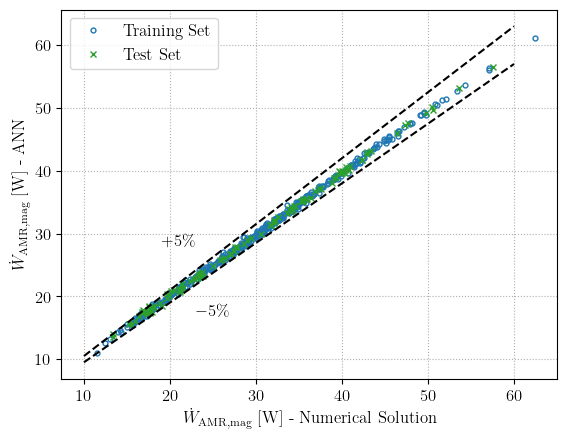

In [21]:
Test_lite(X_train,y_train,'Wm',Scaller)